In [37]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from solar_cell import all_series_bypass, SP_interconnection, TCT_interconnection
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=4096, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        self.fc3 = nn.Linear(mdim, mdim)
        outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        #outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        #print(x.shape)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        
        x = F.relu(x)
        #x = x.bool()
        
        return x

model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)
for param in model.parameters():
  print(param.dtype)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


[array([[0.05479189, 0.        ],
       [0.        , 0.39781491]]), array([[4.13306407, 4.27957256],
       [4.27957256, 5.09450978]]), array([[1.27696105, 0.        ],
       [0.        , 1.47958249]]), array([[1.52955014, 0.        ],
       [0.        , 0.33275249]]), array([[1.46296822, 0.        ],
       [0.        , 0.30882896]]), array([[1.68370856, 0.        ],
       [0.        , 1.6278203 ]]), array([[0.83778888, 1.32895864],
       [1.32895864, 2.93258594]]), array([[0.46312456, 0.        ],
       [0.        , 0.16036045]]), array([[0.56912468, 1.42634841],
       [1.42634841, 3.59638577]]), array([[1.80104905, 0.        ],
       [0.        , 0.39272484]])]


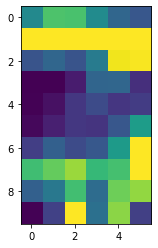

In [39]:
rand_smap = generate_gaussian(10, 10, 6)
plt.imshow(rand_smap)

In [40]:
rand_smap = torch.Tensor(np.expand_dims(rand_smap,0))
print(rand_smap)
print(rand_smap.shape)

tensor([[[ 4.7078,  7.1970,  7.1429,  4.8160,  3.3009,  2.7056],
         [10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000],
         [ 2.5974,  3.3009,  2.5974,  4.1667,  9.7944,  9.9026],
         [ 0.0000,  0.0000,  0.7576,  3.2468,  3.3009,  1.3528],
         [ 0.0541,  0.4329,  1.6234,  2.2727,  1.5693,  1.7857],
         [ 0.2165,  0.8658,  1.6234,  1.5152,  2.7056,  5.5195],
         [ 1.8398,  3.0844,  2.2727,  2.7597,  5.4654, 10.0000],
         [ 6.9264,  7.6299,  8.4957,  6.7100,  7.0346, 10.0000],
         [ 3.0844,  4.0043,  6.9805,  3.5173,  7.7922,  8.3874],
         [ 0.0541,  1.9481, 10.0000,  3.6797,  8.2792,  1.8939]]])
torch.Size([1, 10, 6])


In [41]:
result = model(rand_smap)
print(result)
print(result.shape)

tensor([[0.0549, 0.0093, 0.0000,  ..., 0.1292, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
torch.Size([1, 10920])


In [44]:
""" Generate 10x6 Shading Maps"""
filename = '10x6shading_maps.csv'
maps = []
for x in range(0, 1000):
    rand_smap = generate_gaussian(10, 10, 6)
    maps.append(rand_smap)

maps = pd.Series(maps, name='Shading Maps')
maps.to_csv(filename)

[array([[1.49914091, 0.        ],
       [0.        , 1.22529012]]), array([[3.37656291, 2.29666626],
       [2.29666626, 4.60641373]]), array([[1.58701644, 0.        ],
       [0.        , 1.0204459 ]]), array([[3.54504252, 1.2483775 ],
       [1.2483775 , 0.72193222]]), array([[2.17480391, 1.68442451],
       [1.68442451, 1.88720375]]), array([[1.28953512, 1.08276581],
       [1.08276581, 1.0250857 ]]), array([[1.01230605, 0.        ],
       [0.        , 1.4660379 ]]), array([[0.53698719, 0.24444272],
       [0.24444272, 0.35735098]]), array([[2.8103926 , 2.36925759],
       [2.36925759, 2.01068034]]), array([[3.48481013, 3.79463842],
       [3.79463842, 4.54217892]])]
[array([[3.6516666 , 1.64800404],
       [1.64800404, 1.4607659 ]]), array([[1.97293903, 0.        ],
       [0.        , 1.79219381]]), array([[4.49879498, 1.86576572],
       [1.86576572, 2.31439348]]), array([[2.63072357, 3.40403621],
       [3.40403621, 4.6102081 ]]), array([[4.5552114 , 5.59451753],
       [5.594

[array([[0.63315774, 1.28566806],
       [1.28566806, 4.85118121]]), array([[6.02744427, 0.9084891 ],
       [0.9084891 , 0.22595769]]), array([[2.65753266, 1.2859593 ],
       [1.2859593 , 0.94242199]]), array([[1.38283698, 0.        ],
       [0.        , 1.83759265]]), array([[0.37858615, 0.        ],
       [0.        , 0.22689775]]), array([[1.33516371, 0.        ],
       [0.        , 0.30633776]]), array([[3.34077047, 3.54720404],
       [3.54720404, 3.80928735]]), array([[0.79475358, 0.84799668],
       [0.84799668, 2.55884441]]), array([[4.3294287 , 4.43866816],
       [4.43866816, 5.7246014 ]]), array([[1.42357371, 0.        ],
       [0.        , 1.90461934]])]
[array([[0.02158498, 0.        ],
       [0.        , 1.57591295]]), array([[5.62082009, 2.7139959 ],
       [2.7139959 , 2.12781432]]), array([[1.91028626, 2.10569417],
       [2.10569417, 2.64065786]]), array([[0.20028015, 0.        ],
       [0.        , 0.35033268]]), array([[0.63611185, 0.        ],
       [0.   

[array([[0.00200719, 0.        ],
       [0.        , 0.64256055]]), array([[0.18660754, 1.05395969],
       [1.05395969, 6.01663489]]), array([[5.72718073, 5.38843591],
       [5.38843591, 5.18671027]]), array([[0.34776354, 0.        ],
       [0.        , 0.44727764]]), array([[1.47000416, 0.        ],
       [0.        , 0.68291514]]), array([[1.64045626, 0.        ],
       [0.        , 0.62365843]]), array([[1.58853851, 0.55418968],
       [0.55418968, 2.23369487]]), array([[1.56266069, 0.33449007],
       [0.33449007, 0.07159815]]), array([[1.02904424, 0.50254458],
       [0.50254458, 0.26720451]]), array([[1.82156965, 0.        ],
       [0.        , 1.52039971]])]
[array([[4.53672829, 1.24451765],
       [1.24451765, 0.43485841]]), array([[0.57676212, 0.        ],
       [0.        , 1.89094839]]), array([[1.86446377, 0.        ],
       [0.        , 0.4415232 ]]), array([[2.1605684 , 0.6272667 ],
       [0.6272667 , 0.41640217]]), array([[5.93564723, 5.79202522],
       [5.792

[array([[2.5964093 , 1.85309674],
       [1.85309674, 3.17266141]]), array([[0.40253471, 0.        ],
       [0.        , 0.91797234]]), array([[0.52136145, 0.        ],
       [0.        , 1.70569416]]), array([[0.54202189, 0.        ],
       [0.        , 1.61220343]]), array([[6.30682857, 1.43797419],
       [1.43797419, 0.34199482]]), array([[2.4891778 , 1.48896594],
       [1.48896594, 1.89666269]]), array([[2.00876175, 2.46545126],
       [2.46545126, 3.73054811]]), array([[0.89569191, 0.        ],
       [0.        , 1.25584117]]), array([[3.23698158, 3.8366847 ],
       [3.8366847 , 4.83911827]]), array([[3.48573811, 2.80022553],
       [2.80022553, 2.92186663]])]
[array([[5.97013924, 3.8541209 ],
       [3.8541209 , 3.08595827]]), array([[5.52745735, 2.79563334],
       [2.79563334, 1.91163047]]), array([[0.26467756, 0.        ],
       [0.        , 1.54245571]]), array([[1.89522165, 0.        ],
       [0.        , 1.98741547]]), array([[0.72455945, 0.        ],
       [0.   

[array([[2.68267458, 4.36927521],
       [4.36927521, 7.21433283]]), array([[1.00294887, 0.        ],
       [0.        , 1.10860188]]), array([[1.44356647, 0.        ],
       [0.        , 1.82908033]]), array([[1.36546522, 1.9370833 ],
       [1.9370833 , 3.09162851]]), array([[1.95064886, 0.        ],
       [0.        , 1.16906613]]), array([[0.28188477, 0.66670945],
       [0.66670945, 1.61005247]]), array([[0.37758226, 0.        ],
       [0.        , 0.53332043]]), array([[1.11064273, 0.        ],
       [0.        , 0.63578683]]), array([[4.27906797, 2.42564072],
       [2.42564072, 1.65086328]]), array([[3.88299744, 0.75981533],
       [0.75981533, 0.76605924]])]
[array([[0.71321021, 0.        ],
       [0.        , 1.37985499]]), array([[1.57065415, 0.        ],
       [0.        , 1.16332601]]), array([[1.1476299 , 1.80840788],
       [1.80840788, 3.30903666]]), array([[5.77112754e-04, 2.40990461e-02],
       [2.40990461e-02, 2.36068268e+00]]), array([[0.90428741, 0.        

[array([[4.5814941 , 2.75162368],
       [2.75162368, 1.80787376]]), array([[0.98651778, 1.87544503],
       [1.87544503, 3.74208605]]), array([[1.82290293, 0.        ],
       [0.        , 0.28542677]]), array([[1.63596054, 0.        ],
       [0.        , 0.10583831]]), array([[0.80079613, 0.        ],
       [0.        , 0.72904001]]), array([[1.24401498, 0.42047236],
       [0.42047236, 0.42529136]]), array([[1.3452698, 0.       ],
       [0.       , 0.7151714]]), array([[1.35030265, 0.        ],
       [0.        , 0.73830004]]), array([[1.63640769, 0.        ],
       [0.        , 1.52926787]]), array([[1.92925953, 0.        ],
       [0.        , 1.77642144]])]
[array([[3.41030262, 3.90069255],
       [3.90069255, 5.95954573]]), array([[2.47615449, 2.78661622],
       [2.78661622, 3.44971826]]), array([[0.98929981, 0.        ],
       [0.        , 1.46152087]]), array([[4.00290305, 2.4019944 ],
       [2.4019944 , 1.46564949]]), array([[1.30147375, 0.        ],
       [0.       

[array([[3.25246697, 3.87575822],
       [3.87575822, 4.65717806]]), array([[0.65100166, 0.        ],
       [0.        , 0.12553236]]), array([[1.23558635, 0.        ],
       [0.        , 0.05985339]]), array([[1.95468714, 0.        ],
       [0.        , 0.96248023]]), array([[0.1934969 , 0.15792747],
       [0.15792747, 0.15196307]]), array([[1.47721855, 0.        ],
       [0.        , 1.81790868]]), array([[1.16588741, 0.        ],
       [0.        , 0.82688107]]), array([[1.33294364, 0.        ],
       [0.        , 0.95618471]]), array([[1.20442642, 0.        ],
       [0.        , 0.00685342]]), array([[0.79103876, 0.        ],
       [0.        , 0.17573485]])]
[array([[1.82789812, 0.        ],
       [0.        , 0.70328687]]), array([[0.00915561, 0.        ],
       [0.        , 0.3588293 ]]), array([[1.63162513, 0.        ],
       [0.        , 0.23414865]]), array([[3.64328192, 3.9740065 ],
       [3.9740065 , 5.08822795]]), array([[1.97169329, 0.        ],
       [0.   

[array([[1.57279122, 1.80632616],
       [1.80632616, 2.09180905]]), array([[0.77798822, 0.        ],
       [0.        , 0.30081093]]), array([[0.34206224, 1.29502783],
       [1.29502783, 5.20313826]]), array([[1.95577137, 0.        ],
       [0.        , 0.358076  ]]), array([[1.86992682, 0.        ],
       [0.        , 1.68248716]]), array([[2.53951781, 1.84227191],
       [1.84227191, 3.57622008]]), array([[0.32680209, 0.        ],
       [0.        , 1.26968979]]), array([[0.36400839, 0.46232625],
       [0.46232625, 3.33672977]]), array([[2.92918898, 2.58637729],
       [2.58637729, 2.29661736]]), array([[0.95687818, 0.        ],
       [0.        , 1.01923836]])]
[array([[0.04820467, 0.        ],
       [0.        , 0.3560026 ]]), array([[4.22676385, 2.80117225],
       [2.80117225, 3.66255591]]), array([[0.1860013 , 0.        ],
       [0.        , 1.69391722]]), array([[0.25418249, 1.0074482 ],
       [1.0074482 , 5.07651005]]), array([[0.01566051, 0.        ],
       [0.   

[array([[7.85588782, 4.21132728],
       [4.21132728, 2.49258852]]), array([[0.75159222, 0.        ],
       [0.        , 0.94208463]]), array([[1.13926837, 0.        ],
       [0.        , 1.95273571]]), array([[0.10155902, 0.        ],
       [0.        , 1.52899338]]), array([[2.37617546, 2.812807  ],
       [2.812807  , 4.4472911 ]]), array([[3.15198847, 2.62383146],
       [2.62383146, 2.189647  ]]), array([[4.33973971, 3.34704365],
       [3.34704365, 2.64163726]]), array([[5.73071669, 1.04284602],
       [1.04284602, 0.2283345 ]]), array([[1.54739482, 2.00978989],
       [2.00978989, 2.73377971]]), array([[1.03039508, 0.        ],
       [0.        , 0.86205339]])]
[array([[0.89834417, 1.68064192],
       [1.68064192, 5.67682601]]), array([[0.34804934, 1.25065443],
       [1.25065443, 4.89146109]]), array([[0.51130414, 0.        ],
       [0.        , 0.71095311]]), array([[0.50669148, 1.29786125],
       [1.29786125, 3.3389214 ]]), array([[1.4331837 , 0.        ],
       [0.   

[array([[0.78956051, 0.        ],
       [0.        , 1.20112989]]), array([[0.1239746 , 0.64381228],
       [0.64381228, 3.35139876]]), array([[1.68761935, 0.        ],
       [0.        , 1.67994913]]), array([[1.99286405, 0.        ],
       [0.        , 1.01334405]]), array([[4.88305571, 5.69612481],
       [5.69612481, 7.18240301]]), array([[1.86570189, 0.        ],
       [0.        , 1.47110437]]), array([[1.41951257, 0.        ],
       [0.        , 0.65605082]]), array([[1.68612116, 0.        ],
       [0.        , 1.49373094]]), array([[0.93290887, 0.        ],
       [0.        , 1.11403864]]), array([[1.24799899, 1.23625464],
       [1.23625464, 2.25987256]])]
[array([[4.69772163, 4.03934306],
       [4.03934306, 3.63740102]]), array([[0.24668097, 0.        ],
       [0.        , 1.42396637]]), array([[1.44786883, 0.        ],
       [0.        , 1.41502477]]), array([[3.62661408, 2.33830899],
       [2.33830899, 4.70114823]]), array([[1.99146537, 0.        ],
       [0.   

[array([[1.06085827, 0.        ],
       [0.        , 0.07923552]]), array([[4.76854953, 5.30873719],
       [5.30873719, 5.91731565]]), array([[1.12667225, 0.47727069],
       [0.47727069, 0.6283529 ]]), array([[1.17042756, 0.        ],
       [0.        , 1.22831218]]), array([[1.61972295, 0.        ],
       [0.        , 1.59467316]]), array([[0.51824977, 1.10817103],
       [1.10817103, 2.87841666]]), array([[5.90805444, 3.0471297 ],
       [3.0471297 , 2.35817735]]), array([[0.11889907, 0.57686242],
       [0.57686242, 2.97930372]]), array([[0.55765249, 0.        ],
       [0.        , 1.78751479]]), array([[0.278944  , 0.86981464],
       [0.86981464, 4.78538102]])]
[array([[2.77603581, 2.38818212],
       [2.38818212, 2.08989329]]), array([[0.04376617, 0.        ],
       [0.        , 1.62014244]]), array([[4.2289376 , 4.31385973],
       [4.31385973, 4.41020329]]), array([[1.90123472, 0.        ],
       [0.        , 1.65931178]]), array([[4.41303055, 2.60484521],
       [2.604

[array([[1.7338389 , 2.36132048],
       [2.36132048, 4.73898835]]), array([[1.46878973, 0.        ],
       [0.        , 0.34830845]]), array([[1.89709058, 0.        ],
       [0.        , 1.08735565]]), array([[1.45864062, 0.        ],
       [0.        , 1.71622191]]), array([[3.16147402, 0.11127624],
       [0.11127624, 0.01857481]]), array([[0.86750085, 1.36945137],
       [1.36945137, 2.35008425]]), array([[1.08989445, 0.        ],
       [0.        , 1.5918445 ]]), array([[1.73529336, 0.        ],
       [0.        , 1.43555137]]), array([[2.22101061, 1.74224903],
       [1.74224903, 1.49888937]]), array([[3.43394728, 1.55954331],
       [1.55954331, 0.96043499]])]
[array([[1.13174372, 0.        ],
       [0.        , 1.0261148 ]]), array([[0.22249932, 0.        ],
       [0.        , 0.43245439]]), array([[3.89031884, 3.97568849],
       [3.97568849, 4.43425669]]), array([[1.84573558, 0.        ],
       [0.        , 1.90088478]]), array([[1.35809246, 0.        ],
       [0.   

[array([[0.45991885, 0.        ],
       [0.        , 0.50765865]]), array([[1.90465384, 0.61239112],
       [0.61239112, 0.94604513]]), array([[0.27195152, 0.        ],
       [0.        , 0.11211651]]), array([[0.96345921, 1.71142031],
       [1.71142031, 3.21369756]]), array([[0.73843511, 0.        ],
       [0.        , 1.34706739]]), array([[1.28138323, 0.        ],
       [0.        , 0.22286923]]), array([[2.70332189, 2.95885834],
       [2.95885834, 4.29634328]]), array([[1.89641001, 2.2913859 ],
       [2.2913859 , 2.81421846]]), array([[0.51188191, 0.        ],
       [0.        , 1.34707811]]), array([[4.54512084, 4.22595007],
       [4.22595007, 4.28486356]])]
[array([[1.3302138 , 0.        ],
       [0.        , 1.69958298]]), array([[0.83914495, 0.        ],
       [0.        , 1.27977892]]), array([[0.77082517, 0.        ],
       [0.        , 0.95245892]]), array([[0.77129843, 0.        ],
       [0.        , 0.70753926]]), array([[0.4231282 , 0.        ],
       [0.   

[array([[2.66302652, 1.14753223],
       [1.14753223, 1.69257693]]), array([[1.70079879, 0.        ],
       [0.        , 0.60527041]]), array([[2.69257879, 2.21617441],
       [2.21617441, 3.61021036]]), array([[0.03220694, 0.        ],
       [0.        , 1.39654403]]), array([[0.94589264, 0.        ],
       [0.        , 1.52021943]]), array([[0.34612651, 0.        ],
       [0.        , 1.8229669 ]]), array([[3.31044452, 3.40052204],
       [3.40052204, 3.9064305 ]]), array([[4.10095526, 5.15329294],
       [5.15329294, 6.81088937]]), array([[0.29004108, 0.        ],
       [0.        , 1.19648704]]), array([[1.16306011, 0.62943608],
       [0.62943608, 3.970175  ]])]
[array([[4.69698639, 3.79301342],
       [3.79301342, 3.45011105]]), array([[1.72582294, 0.        ],
       [0.        , 1.48535785]]), array([[0.99183897, 0.        ],
       [0.        , 1.82523857]]), array([[1.25647484, 0.        ],
       [0.        , 1.58119432]]), array([[4.96427212, 3.76694974],
       [3.766

[array([[1.19144475, 0.        ],
       [0.        , 1.32191861]]), array([[0.85224978, 0.92002872],
       [0.92002872, 0.99867818]]), array([[3.29797601, 1.04569977],
       [1.04569977, 1.64021478]]), array([[4.30010161, 2.98535613],
       [2.98535613, 3.3320144 ]]), array([[1.3249996 , 0.        ],
       [0.        , 0.06887795]]), array([[2.70551907, 1.48514268],
       [1.48514268, 1.01840865]]), array([[2.77590109, 0.71855262],
       [0.71855262, 0.25988622]]), array([[0.23687306, 0.        ],
       [0.        , 1.33923908]]), array([[1.70162743, 0.        ],
       [0.        , 0.5673438 ]]), array([[1.89568241, 0.        ],
       [0.        , 1.08002251]])]
[array([[0.61743779, 0.9500995 ],
       [0.9500995 , 3.39211402]]), array([[1.0904579 , 0.14465886],
       [0.14465886, 1.04270737]]), array([[2.04190809, 2.57713646],
       [2.57713646, 3.29496202]]), array([[0.2583897 , 0.        ],
       [0.        , 1.90666629]]), array([[1.27822104, 0.        ],
       [0.   

[array([[1.46247545, 0.        ],
       [0.        , 1.64286661]]), array([[4.36832486, 2.88725188],
       [2.88725188, 1.91548708]]), array([[1.24615265, 0.        ],
       [0.        , 1.00764814]]), array([[1.82351288, 0.        ],
       [0.        , 0.63804975]]), array([[1.63342644, 2.49321478],
       [2.49321478, 4.38839265]]), array([[7.58140424, 2.43372145],
       [2.43372145, 0.83952101]]), array([[1.31643755, 0.        ],
       [0.        , 1.18508495]]), array([[1.18285789, 0.        ],
       [0.        , 0.37110988]]), array([[0.77608008, 0.        ],
       [0.        , 1.76630667]]), array([[0.09200918, 0.        ],
       [0.        , 0.16768235]])]
[array([[1.24609614, 0.        ],
       [0.        , 1.72141079]]), array([[1.23758448, 1.93589645],
       [1.93589645, 3.02853655]]), array([[0.0949461 , 0.        ],
       [0.        , 0.60925232]]), array([[0.49049468, 0.        ],
       [0.        , 0.13480791]]), array([[1.56772191, 0.79780624],
       [0.797

[array([[4.33673481, 3.83469361],
       [3.83469361, 3.82397769]]), array([[0.92006629, 0.        ],
       [0.        , 1.93986649]]), array([[0.62041013, 0.        ],
       [0.        , 0.02992614]]), array([[1.21060498, 0.        ],
       [0.        , 1.0667102 ]]), array([[1.65293067, 0.        ],
       [0.        , 1.93071365]]), array([[0.63642644, 0.        ],
       [0.        , 0.39494975]]), array([[0.03053449, 0.        ],
       [0.        , 0.32016894]]), array([[2.60109055, 2.66858205],
       [2.66858205, 2.92881579]]), array([[3.90739434, 4.40133686],
       [4.40133686, 5.41179807]]), array([[1.81624957, 0.        ],
       [0.        , 1.1785144 ]])]
[array([[4.47914569, 1.93131979],
       [1.93131979, 0.83724616]]), array([[0.97472034, 0.        ],
       [0.        , 0.14307233]]), array([[1.21145035, 0.        ],
       [0.        , 1.24804479]]), array([[0.13636897, 0.        ],
       [0.        , 0.49164053]]), array([[0.74494744, 0.79910288],
       [0.799

[array([[1.00715261, 0.        ],
       [0.        , 0.18567848]]), array([[1.84307844, 0.        ],
       [0.        , 1.15409664]]), array([[0.18389223, 0.        ],
       [0.        , 0.80335825]]), array([[1.91327047, 0.        ],
       [0.        , 1.40095366]]), array([[0.68470624, 0.        ],
       [0.        , 1.63026988]]), array([[2.62628654, 2.17643319],
       [2.17643319, 1.85941321]]), array([[0.52216148, 0.        ],
       [0.        , 1.62907334]]), array([[0.63872185, 0.        ],
       [0.        , 0.87598338]]), array([[1.35357291, 0.        ],
       [0.        , 0.83168914]]), array([[1.09042528, 1.98061023],
       [1.98061023, 4.85056276]])]
[array([[0.26029029, 0.82330332],
       [0.82330332, 3.28936815]]), array([[1.02506211, 0.        ],
       [0.        , 0.43488877]]), array([[0.03204697, 0.        ],
       [0.        , 0.27749954]]), array([[0.63302743, 0.        ],
       [0.        , 0.48153722]]), array([[1.9320512 , 0.        ],
       [0.   

[array([[3.18074055, 3.19287851],
       [3.19287851, 3.69238566]]), array([[4.41342497, 2.71523544],
       [2.71523544, 2.00602284]]), array([[1.16339141, 0.        ],
       [0.        , 1.45328879]]), array([[1.79047363, 0.        ],
       [0.        , 0.83945509]]), array([[3.9336768 , 3.68199043],
       [3.68199043, 3.4716524 ]]), array([[1.48316801, 0.        ],
       [0.        , 1.98439994]]), array([[1.06960411, 0.94043558],
       [0.94043558, 1.01977632]]), array([[0.57310645, 0.75974461],
       [0.75974461, 1.30645843]]), array([[1.30387278, 0.        ],
       [0.        , 1.36938643]]), array([[4.82786777, 1.80406682],
       [1.80406682, 3.1256104 ]])]
[array([[3.96023661, 2.61111769],
       [2.61111769, 2.41084583]]), array([[0.69277339, 0.        ],
       [0.        , 1.28995675]]), array([[0.00470936, 0.        ],
       [0.        , 1.43034963]]), array([[1.95980711, 0.        ],
       [0.        , 1.3894961 ]]), array([[1.35903836, 0.        ],
       [0.   

[array([[0.58500033, 0.        ],
       [0.        , 1.00149815]]), array([[3.14127906, 4.36829146],
       [4.36829146, 6.31663506]]), array([[0.29717532, 0.        ],
       [0.        , 0.62225168]]), array([[2.3989341 , 1.72282382],
       [1.72282382, 1.30133662]]), array([[3.15445951, 2.69270224],
       [2.69270224, 3.64350987]]), array([[2.55059001, 1.78480515],
       [1.78480515, 1.25304798]]), array([[0.99303256, 1.30190043],
       [1.30190043, 3.94980189]]), array([[0.03396036, 0.        ],
       [0.        , 1.05834454]]), array([[0.97558596, 0.        ],
       [0.        , 0.5263586 ]]), array([[3.99194781, 0.56061108],
       [0.56061108, 0.46441181]])]
[array([[1.47528701, 0.        ],
       [0.        , 0.07916952]]), array([[2.84551048, 0.91953871],
       [0.91953871, 0.54304552]]), array([[0.19678885, 0.65077385],
       [0.65077385, 2.44849383]]), array([[0.13178195, 0.        ],
       [0.        , 0.24038346]]), array([[1.87661228, 0.        ],
       [0.   

[array([[0.34985876, 0.65119214],
       [0.65119214, 2.34077135]]), array([[1.43180559, 0.        ],
       [0.        , 1.8377629 ]]), array([[1.04331932, 0.        ],
       [0.        , 1.69636096]]), array([[1.83547932, 0.        ],
       [0.        , 1.14519259]]), array([[1.87077367, 1.15741501],
       [1.15741501, 2.47436428]]), array([[0.49385772, 0.        ],
       [0.        , 1.16338476]]), array([[2.93699047, 0.37292888],
       [0.37292888, 0.04747091]]), array([[0.80626835, 0.        ],
       [0.        , 0.27530561]]), array([[0.46195946, 0.        ],
       [0.        , 0.85950002]]), array([[0.84797566, 0.43630503],
       [0.43630503, 2.49718568]])]
[array([[1.94571181, 0.73871639],
       [0.73871639, 0.36782871]]), array([[3.53500022, 2.21994387],
       [2.21994387, 1.45424277]]), array([[0.35283693, 0.51729001],
       [0.51729001, 1.48711239]]), array([[3.76602161, 2.98473236],
       [2.98473236, 2.51513337]]), array([[1.27580191, 0.        ],
       [0.   

[array([[0.41530666, 0.        ],
       [0.        , 1.25328998]]), array([[0.90312463, 0.        ],
       [0.        , 0.8908443 ]]), array([[3.86448403, 1.08202489],
       [1.08202489, 1.40767106]]), array([[1.64964837, 1.96811227],
       [1.96811227, 4.36494405]]), array([[4.02731547, 0.76728123],
       [0.76728123, 3.94831264]]), array([[1.53451041, 0.        ],
       [0.        , 1.68223829]]), array([[5.10515666, 1.0625895 ],
       [1.0625895 , 0.42608152]]), array([[1.50643007, 0.        ],
       [0.        , 1.39649347]]), array([[4.78421621e-03, 1.38834781e-01],
       [1.38834781e-01, 5.17064266e+00]]), array([[1.6962272 , 0.        ],
       [0.        , 0.94306774]])]
[array([[0.57517045, 0.        ],
       [0.        , 1.60235976]]), array([[1.87183313, 2.89667494],
       [2.89667494, 4.48538057]]), array([[0.2937596 , 0.        ],
       [0.        , 1.32033557]]), array([[1.97177829, 0.        ],
       [0.        , 0.12402566]]), array([[6.00611438, 5.77464922

[array([[1.53189807, 0.        ],
       [0.        , 0.36268405]]), array([[0.92274804, 1.14467924],
       [1.14467924, 2.22011777]]), array([[1.12380189, 0.        ],
       [0.        , 1.33576408]]), array([[2.14201836, 1.3721307 ],
       [1.3721307 , 3.4377527 ]]), array([[0.64389759, 0.        ],
       [0.        , 0.54788292]]), array([[1.59928472, 0.        ],
       [0.        , 1.84017296]]), array([[3.37161863, 3.31039292],
       [3.31039292, 4.22354361]]), array([[2.47453166, 3.64212481],
       [3.64212481, 5.40419033]]), array([[1.47304827, 2.15175187],
       [2.15175187, 3.51576755]]), array([[1.2488425 , 1.13250008],
       [1.13250008, 1.28651141]])]
[array([[1.59820603, 0.08954943],
       [0.08954943, 0.01490248]]), array([[1.07263609, 0.        ],
       [0.        , 0.90631531]]), array([[0.37825171, 0.43767757],
       [0.43767757, 2.64966054]]), array([[1.97443876, 0.56259087],
       [0.56259087, 0.16772617]]), array([[0.99467517, 2.35692259],
       [2.356

[array([[2.7917437 , 0.32202434],
       [0.32202434, 0.04968506]]), array([[2.98653486, 3.31825811],
       [3.31825811, 4.08488788]]), array([[0.5704406, 0.       ],
       [0.       , 0.9873864]]), array([[4.16572723, 2.79138228],
       [2.79138228, 3.35404694]]), array([[2.27344224, 1.80048256],
       [1.80048256, 1.43256773]]), array([[3.79909495, 3.51685968],
       [3.51685968, 3.26088795]]), array([[4.43379801, 2.65075837],
       [2.65075837, 2.55083955]]), array([[0.34639207, 0.        ],
       [0.        , 1.61549918]]), array([[4.94952998, 5.16300059],
       [5.16300059, 5.83913051]]), array([[1.59065789, 0.        ],
       [0.        , 1.0024483 ]])]
[array([[3.48855468, 2.60668316],
       [2.60668316, 2.78264662]]), array([[1.66191008, 0.4101267 ],
       [0.4101267 , 3.39012277]]), array([[0.80186165, 0.        ],
       [0.        , 0.01633703]]), array([[0.99958669, 1.78454747],
       [1.78454747, 3.45023562]]), array([[0.67201063, 0.        ],
       [0.       

[array([[3.46198418, 1.09172223],
       [1.09172223, 0.848932  ]]), array([[3.17844574, 2.64532121],
       [2.64532121, 2.60887557]]), array([[1.24882093, 0.32498639],
       [0.32498639, 0.15524375]]), array([[0.19888657, 0.        ],
       [0.        , 0.53062221]]), array([[1.36033622, 0.53778115],
       [0.53778115, 0.21326928]]), array([[1.87706194, 0.        ],
       [0.        , 0.79016472]]), array([[1.13103114, 0.        ],
       [0.        , 0.8201057 ]]), array([[0.33395944, 0.        ],
       [0.        , 0.13822931]]), array([[0.25022075, 0.75528684],
       [0.75528684, 3.45777366]]), array([[1.49929329, 0.60880658],
       [0.60880658, 0.28990623]])]
[array([[0.01772284, 0.        ],
       [0.        , 1.07751633]]), array([[1.40821371, 0.        ],
       [0.        , 0.91387781]]), array([[0.50098918, 0.        ],
       [0.        , 0.51058819]]), array([[2.67571273, 1.30728818],
       [1.30728818, 0.64297338]]), array([[2.76161614, 1.62160957],
       [1.621

[array([[0.67992232, 1.45131054],
       [1.45131054, 4.76985219]]), array([[1.6752207 , 0.        ],
       [0.        , 1.63127526]]), array([[3.460107  , 2.3347951 ],
       [2.3347951 , 1.61187001]]), array([[4.16413196, 3.6923135 ],
       [3.6923135 , 3.92470536]]), array([[4.4364067 , 1.58536157],
       [1.58536157, 0.65583935]]), array([[1.34036587, 0.        ],
       [0.        , 0.56073901]]), array([[3.85596174, 2.83463359],
       [2.83463359, 3.52504041]]), array([[0.87365015, 0.        ],
       [0.        , 1.44118672]]), array([[0.14085477, 0.21611114],
       [0.21611114, 1.5683262 ]]), array([[4.0661191 , 1.64340423],
       [1.64340423, 1.01578021]])]
[array([[1.87131749, 0.        ],
       [0.        , 0.02991133]]), array([[5.74785504, 5.6140997 ],
       [5.6140997 , 5.73668654]]), array([[2.92985761, 3.34337705],
       [3.34337705, 3.8169355 ]]), array([[0.57722774, 0.        ],
       [0.        , 1.31684721]]), array([[0.95892249, 1.98712314],
       [1.987

[array([[5.85476288, 2.79618918],
       [2.79618918, 1.81377106]]), array([[3.51479568, 2.96285242],
       [2.96285242, 2.50978356]]), array([[0.17190274, 0.        ],
       [0.        , 0.23063175]]), array([[1.94122483, 2.4680986 ],
       [2.4680986 , 3.45611292]]), array([[1.7018769 , 0.47836593],
       [0.47836593, 0.13581905]]), array([[1.68000359, 0.        ],
       [0.        , 1.1753031 ]]), array([[0.29456888, 0.        ],
       [0.        , 1.8768967 ]]), array([[1.4867712 , 0.        ],
       [0.        , 0.20946685]]), array([[5.25652722, 3.92879428],
       [3.92879428, 3.80094573]]), array([[2.21835476, 1.45551394],
       [1.45551394, 1.08314269]])]
[array([[4.62848326, 3.14114421],
       [3.14114421, 2.21726109]]), array([[0.31061813, 0.52478682],
       [0.52478682, 0.95358026]]), array([[6.28749028, 6.68118274],
       [6.68118274, 7.15847057]]), array([[1.97388981, 0.        ],
       [0.        , 1.82684364]]), array([[0.96356795, 0.        ],
       [0.   

[array([[4.7088532 , 2.11422505],
       [2.11422505, 0.95144764]]), array([[0.94245083, 0.        ],
       [0.        , 0.07293639]]), array([[3.24985437, 1.31172676],
       [1.31172676, 0.56625276]]), array([[0.52240697, 1.50046542],
       [1.50046542, 4.5261279 ]]), array([[0.22121559, 0.        ],
       [0.        , 0.26469526]]), array([[0.4244029 , 0.        ],
       [0.        , 1.70356852]]), array([[1.20182593, 1.20297489],
       [1.20297489, 1.20813811]]), array([[0.03578538, 0.        ],
       [0.        , 1.0417894 ]]), array([[1.35943731, 0.        ],
       [0.        , 1.71349281]]), array([[0.62897873, 0.76474053],
       [0.76474053, 1.28390054]])]
[array([[0.71023097, 0.        ],
       [0.        , 1.24618776]]), array([[1.5156057 , 0.        ],
       [0.        , 0.91816809]]), array([[0.32109668, 0.        ],
       [0.        , 1.3101874 ]]), array([[1.62367591, 0.        ],
       [0.        , 1.56677471]]), array([[0.69145759, 0.        ],
       [0.   

[array([[1.66823913, 0.54803452],
       [0.54803452, 0.51421742]]), array([[0.34841799, 0.        ],
       [0.        , 0.21495188]]), array([[1.29600683, 0.        ],
       [0.        , 1.96508171]]), array([[1.68378861, 0.        ],
       [0.        , 1.49154095]]), array([[0.69501056, 0.        ],
       [0.        , 1.10640766]]), array([[0.81829306, 0.        ],
       [0.        , 1.09034669]]), array([[1.4268244 , 0.52379617],
       [0.52379617, 0.52314048]]), array([[1.28078711, 0.        ],
       [0.        , 1.59417675]]), array([[0.39140112, 0.        ],
       [0.        , 0.13664027]]), array([[0.19380754, 0.        ],
       [0.        , 0.32352474]])]
[array([[0.02616723, 0.        ],
       [0.        , 0.14092161]]), array([[0.37300243, 0.        ],
       [0.        , 0.15752958]]), array([[2.90935416, 2.8597327 ],
       [2.8597327 , 2.81131519]]), array([[4.36900243, 3.91987586],
       [3.91987586, 3.52040085]]), array([[0.15236268, 0.        ],
       [0.   

[array([[1.98444923, 0.        ],
       [0.        , 0.17993887]]), array([[0.66068538, 0.        ],
       [0.        , 1.89369877]]), array([[0.42545501, 0.        ],
       [0.        , 0.07753739]]), array([[2.5703769 , 2.21598369],
       [2.21598369, 1.9431063 ]]), array([[0.34772199, 0.        ],
       [0.        , 1.32204714]]), array([[1.90203084, 0.        ],
       [0.        , 1.10611847]]), array([[1.48831544, 0.        ],
       [0.        , 0.96771698]]), array([[0.74556606, 0.        ],
       [0.        , 1.15265058]]), array([[4.21111451, 0.36808319],
       [0.36808319, 0.07453843]]), array([[4.16373604, 1.54653638],
       [1.54653638, 0.78657523]])]
[array([[5.53174463, 2.19735163],
       [2.19735163, 1.16508847]]), array([[1.4014202 , 0.        ],
       [0.        , 1.30840868]]), array([[3.96647029, 3.31305643],
       [3.31305643, 3.08490421]]), array([[0.23320446, 0.        ],
       [0.        , 1.42524523]]), array([[3.10974977, 2.1434393 ],
       [2.143

[array([[0.38895118, 0.        ],
       [0.        , 1.75551223]]), array([[3.42941562, 2.82750808],
       [2.82750808, 2.33184644]]), array([[1.16674694, 0.        ],
       [0.        , 0.93203349]]), array([[1.58233544, 0.        ],
       [0.        , 1.07084498]]), array([[4.29476977, 3.60508882],
       [3.60508882, 3.55719153]]), array([[0.50660924, 0.64764649],
       [0.64764649, 0.84456822]]), array([[0.06802878, 0.        ],
       [0.        , 0.74033282]]), array([[2.36371458, 1.98467043],
       [1.98467043, 1.68539732]]), array([[2.61811216, 0.99497673],
       [0.99497673, 0.37817364]]), array([[4.20851412, 0.39237423],
       [0.39237423, 0.05329144]])]
[array([[4.08922873, 2.18375966],
       [2.18375966, 2.3693406 ]]), array([[1.85634508, 1.5709634 ],
       [1.5709634 , 2.64093666]]), array([[1.80261438, 2.38773441],
       [2.38773441, 3.6238072 ]]), array([[1.26342538, 0.72744147],
       [0.72744147, 0.48773421]]), array([[1.22966549, 0.        ],
       [0.   

[array([[4.73974498, 4.3905808 ],
       [4.3905808 , 4.06742857]]), array([[3.51421931, 4.11413626],
       [4.11413626, 5.31009443]]), array([[2.07609073, 0.96701142],
       [0.96701142, 0.46176989]]), array([[1.25446238, 0.        ],
       [0.        , 0.83069327]]), array([[1.3499835 , 0.        ],
       [0.        , 0.83542317]]), array([[0.29846317, 0.67802776],
       [0.67802776, 2.43591642]]), array([[1.62099325, 0.        ],
       [0.        , 1.23237937]]), array([[0.73285157, 0.        ],
       [0.        , 1.30962231]]), array([[0.28553458, 1.10028863],
       [1.10028863, 7.44786128]]), array([[0.09165759, 0.        ],
       [0.        , 0.3720133 ]])]
[array([[2.49275835, 3.67197812],
       [3.67197812, 6.45529343]]), array([[1.10853837, 0.        ],
       [0.        , 0.50329923]]), array([[1.67981484, 0.        ],
       [0.        , 1.73120243]]), array([[1.31825101, 1.25885999],
       [1.25885999, 1.70567664]]), array([[0.18274894, 0.40340177],
       [0.403

[array([[0.26178715, 0.        ],
       [0.        , 1.7632002 ]]), array([[1.67359949, 0.        ],
       [0.        , 0.29651492]]), array([[1.59955133, 0.        ],
       [0.        , 1.46686793]]), array([[1.02792992, 0.        ],
       [0.        , 1.48829864]]), array([[1.59498591, 1.63601193],
       [1.63601193, 1.67993125]]), array([[1.89248457, 0.        ],
       [0.        , 0.06711688]]), array([[1.62307006, 0.58683002],
       [0.58683002, 0.28500508]]), array([[0.54795139, 0.56744565],
       [0.56744565, 1.17541371]]), array([[0.37770914, 0.        ],
       [0.        , 1.36276091]]), array([[1.67381026, 0.        ],
       [0.        , 1.44654847]])]
[array([[1.62070248, 0.74280658],
       [0.74280658, 0.34110685]]), array([[0.69754682, 0.        ],
       [0.        , 1.36389357]]), array([[0.01828268, 0.        ],
       [0.        , 1.95072309]]), array([[2.02601534, 2.74441583],
       [2.74441583, 3.79481609]]), array([[2.43354  , 2.1924561],
       [2.19245

[array([[2.81435376, 0.31927121],
       [0.31927121, 0.03863055]]), array([[1.4852815 , 0.        ],
       [0.        , 0.35449548]]), array([[1.46205605, 2.15983827],
       [2.15983827, 3.19102692]]), array([[1.9177328 , 0.        ],
       [0.        , 1.25990878]]), array([[2.20550281, 2.35452555],
       [2.35452555, 3.0984434 ]]), array([[7.12172508, 4.58200323],
       [4.58200323, 3.1034373 ]]), array([[0.89312922, 0.        ],
       [0.        , 1.86460343]]), array([[0.49604677, 0.        ],
       [0.        , 0.32239474]]), array([[7.74110039, 4.34500448],
       [4.34500448, 3.81348144]]), array([[0.93669965, 0.55503347],
       [0.55503347, 0.46401877]])]
[array([[0.20151124, 0.        ],
       [0.        , 1.60651234]]), array([[0.14662434, 0.        ],
       [0.        , 1.55550441]]), array([[3.6382242 , 4.1100906 ],
       [4.1100906 , 5.12471606]]), array([[0.06199253, 0.        ],
       [0.        , 1.50227163]]), array([[1.80575417, 1.71243402],
       [1.712

[array([[1.37124058, 2.13991359],
       [2.13991359, 3.34045806]]), array([[1.75217681, 0.        ],
       [0.        , 0.93300617]]), array([[1.15782861, 0.        ],
       [0.        , 0.30720341]]), array([[0.23230674, 0.        ],
       [0.        , 1.27200313]]), array([[1.07872326, 0.68079285],
       [0.68079285, 0.43082953]]), array([[6.66270301, 2.96047572],
       [2.96047572, 1.43850331]]), array([[1.59439559, 0.        ],
       [0.        , 1.84418353]]), array([[0.22266519, 0.        ],
       [0.        , 1.63010227]]), array([[1.68014004, 0.        ],
       [0.        , 1.04806452]]), array([[5.29697118, 5.35554131],
       [5.35554131, 5.98623274]])]
[array([[1.12046836, 0.        ],
       [0.        , 1.62422279]]), array([[4.14876468, 0.94804738],
       [0.94804738, 0.42138126]]), array([[0.36015733, 0.80574513],
       [0.80574513, 3.56759282]]), array([[1.9721408 , 0.        ],
       [0.        , 1.55258746]]), array([[4.04695607, 2.41858983],
       [2.418

[array([[0.95358963, 0.        ],
       [0.        , 1.03253362]]), array([[1.45138522, 0.        ],
       [0.        , 1.28769155]]), array([[1.67230952, 0.        ],
       [0.        , 0.18229592]]), array([[1.08046377, 0.        ],
       [0.        , 1.21288469]]), array([[1.36666654, 0.        ],
       [0.        , 1.85909269]]), array([[3.08062182, 2.24888602],
       [2.24888602, 2.50498678]]), array([[4.27813213, 3.61520847],
       [3.61520847, 3.30203494]]), array([[0.79562702, 0.        ],
       [0.        , 1.60818811]]), array([[1.58167947, 1.19715829],
       [1.19715829, 0.90721452]]), array([[3.80062702, 4.60832754],
       [4.60832754, 5.68186785]])]
[array([[1.54513519, 0.49337512],
       [0.49337512, 0.16114384]]), array([[0.21717145, 0.        ],
       [0.        , 0.39872636]]), array([[1.62988675, 1.742148  ],
       [1.742148  , 2.07785274]]), array([[1.71998367, 1.37563799],
       [1.37563799, 2.01498163]]), array([[2.59670173, 0.69535672],
       [0.695

[array([[1.14584133, 0.        ],
       [0.        , 0.9207439 ]]), array([[0.46963965, 0.        ],
       [0.        , 0.35586111]]), array([[0.27326912, 1.01713196],
       [1.01713196, 4.2664562 ]]), array([[0.81479576, 0.        ],
       [0.        , 1.92028725]]), array([[4.29059131, 2.45546789],
       [2.45546789, 2.86711528]]), array([[1.10580537, 0.        ],
       [0.        , 1.89506194]]), array([[1.01060148, 0.        ],
       [0.        , 0.36069427]]), array([[2.6218346 , 3.37937331],
       [3.37937331, 4.68584288]]), array([[1.60374074, 0.58704861],
       [0.58704861, 0.41875453]]), array([[1.52499766, 0.        ],
       [0.        , 1.7895289 ]])]
[array([[4.92190507, 1.51428485],
       [1.51428485, 0.47048677]]), array([[2.81653728, 2.13836605],
       [2.13836605, 1.62460221]]), array([[2.6756915 , 0.28589751],
       [0.28589751, 0.50741007]]), array([[3.80601349, 1.11381151],
       [1.11381151, 0.34017264]]), array([[3.49732063, 3.49827457],
       [3.498

[array([[1.51054532, 2.72009711],
       [2.72009711, 6.55607319]]), array([[1.35143996, 0.92248092],
       [0.92248092, 0.80545626]]), array([[4.5646342 , 2.97208562],
       [2.97208562, 2.80788864]]), array([[1.13809727, 0.        ],
       [0.        , 1.47391151]]), array([[0.04479957, 0.        ],
       [0.        , 0.75480604]]), array([[1.49183388, 1.94110939],
       [1.94110939, 4.30879698]]), array([[0.74357431, 0.        ],
       [0.        , 1.1946778 ]]), array([[1.67276283, 0.        ],
       [0.        , 0.53665811]]), array([[0.96068039, 0.        ],
       [0.        , 1.6181298 ]]), array([[0.15161768, 0.6149583 ],
       [0.6149583 , 4.64617326]])]
[array([[2.01828171, 0.61728018],
       [0.61728018, 3.15366942]]), array([[1.26496212, 0.        ],
       [0.        , 1.20923034]]), array([[2.66291237, 1.09265275],
       [1.09265275, 0.66764635]]), array([[0.34766828, 0.        ],
       [0.        , 0.05690659]]), array([[4.36714143, 2.48015515],
       [2.480

[array([[0.92172808, 0.        ],
       [0.        , 1.14223233]]), array([[0.29445209, 0.        ],
       [0.        , 0.67218296]]), array([[3.84419729, 1.30511328],
       [1.30511328, 1.76913421]]), array([[0.44797365, 0.        ],
       [0.        , 0.98744205]]), array([[1.35136597, 0.        ],
       [0.        , 1.36388517]]), array([[0.6217477 , 0.        ],
       [0.        , 0.17185069]]), array([[5.63024254, 4.08937258],
       [4.08937258, 3.65162299]]), array([[1.65937489, 0.        ],
       [0.        , 0.91618585]]), array([[0.73332811, 0.        ],
       [0.        , 1.04904038]]), array([[1.51717762, 0.        ],
       [0.        , 1.13298954]])]
[array([[1.18928534, 0.34751401],
       [0.34751401, 1.46379309]]), array([[2.10578561, 2.30849169],
       [2.30849169, 2.64865242]]), array([[2.1038781 , 1.78599392],
       [1.78599392, 3.18685411]]), array([[2.5184757 , 2.61072111],
       [2.61072111, 2.72741557]]), array([[0.23595842, 0.44953785],
       [0.449

[array([[0.43086894, 0.        ],
       [0.        , 0.59396855]]), array([[0.28748994, 0.        ],
       [0.        , 1.48763422]]), array([[0.14969311, 0.46525943],
       [0.46525943, 2.25316871]]), array([[0.80110614, 0.        ],
       [0.        , 0.86225684]]), array([[0.11613129, 0.        ],
       [0.        , 0.79065987]]), array([[0.46059614, 0.        ],
       [0.        , 0.90319856]]), array([[0.28338573, 1.11358986],
       [1.11358986, 4.50484674]]), array([[1.27292699, 0.        ],
       [0.        , 0.12289386]]), array([[1.42123338, 1.09492792],
       [1.09492792, 2.89680734]]), array([[0.09760522, 0.        ],
       [0.        , 1.46682677]])]
[array([[0.43712834, 0.        ],
       [0.        , 0.83765641]]), array([[0.52638847, 0.53995408],
       [0.53995408, 1.23134944]]), array([[0.58136183, 1.38922519],
       [1.38922519, 4.22075283]]), array([[2.47236485, 1.66221138],
       [1.66221138, 1.22388358]]), array([[2.48157508, 0.89206639],
       [0.892

[array([[1.05612835, 1.08654879],
       [1.08654879, 1.48555545]]), array([[0.68434264, 1.11599823],
       [1.11599823, 2.75345775]]), array([[0.23212279, 0.        ],
       [0.        , 0.21530463]]), array([[0.74129094, 0.        ],
       [0.        , 0.79026538]]), array([[0.94430751, 0.        ],
       [0.        , 1.07310117]]), array([[3.16426109, 3.81713757],
       [3.81713757, 4.7181555 ]]), array([[1.49004267, 0.        ],
       [0.        , 0.36641291]]), array([[1.10922401, 1.20305041],
       [1.20305041, 1.87932873]]), array([[4.89953099, 2.33788926],
       [2.33788926, 2.13231957]]), array([[2.57346876, 3.68199375],
       [3.68199375, 6.5501307 ]])]
[array([[0.51344789, 1.27901864],
       [1.27901864, 3.788874  ]]), array([[0.81327909, 0.        ],
       [0.        , 0.47536795]]), array([[4.1883339 , 0.86405484],
       [0.86405484, 0.35877556]]), array([[1.02597866, 0.66355808],
       [0.66355808, 0.44452019]]), array([[3.24005644, 2.93578425],
       [2.935

[array([[2.07112331, 2.31470131],
       [2.31470131, 3.33547743]]), array([[1.69720544, 0.        ],
       [0.        , 0.41339065]]), array([[0.20592665, 0.        ],
       [0.        , 0.83020881]]), array([[1.46633147, 0.        ],
       [0.        , 0.55206783]]), array([[0.36140823, 0.        ],
       [0.        , 0.21371082]]), array([[0.19013412, 0.        ],
       [0.        , 0.97163563]]), array([[0.81610787, 0.        ],
       [0.        , 0.13350404]]), array([[1.17789145, 0.        ],
       [0.        , 0.31266628]]), array([[1.62123351, 0.        ],
       [0.        , 1.23304198]]), array([[0.41687067, 0.        ],
       [0.        , 1.81298587]])]
[array([[0.84130526, 0.        ],
       [0.        , 1.12085003]]), array([[1.36750896, 0.        ],
       [0.        , 1.99307314]]), array([[2.95666923, 1.82291947],
       [1.82291947, 1.31176745]]), array([[0.25668525, 0.83752879],
       [0.83752879, 2.96609163]]), array([[6.83073973, 4.3535605 ],
       [4.353

[array([[1.58722895, 0.        ],
       [0.        , 1.03784482]]), array([[0.56911937, 0.        ],
       [0.        , 1.03011723]]), array([[1.6922058 , 0.        ],
       [0.        , 0.12374483]]), array([[1.44211408, 0.2394926 ],
       [0.2394926 , 0.04572238]]), array([[4.73000398, 1.59676745],
       [1.59676745, 1.60379308]]), array([[0.95566496, 0.        ],
       [0.        , 0.90070104]]), array([[0.99718729, 1.18243315],
       [1.18243315, 1.41123184]]), array([[1.09730637, 2.04350536],
       [2.04350536, 3.89941968]]), array([[2.33110392, 1.65048283],
       [1.65048283, 1.18345063]]), array([[2.39397392, 3.39960878],
       [3.39960878, 5.63410913]])]
[array([[0.03885692, 0.        ],
       [0.        , 1.69512483]]), array([[0.98638453, 0.6492791 ],
       [0.6492791 , 1.19908392]]), array([[0.92160321, 1.82790921],
       [1.82790921, 5.10643655]]), array([[0.78257141, 1.09564928],
       [1.09564928, 3.38608424]]), array([[0.04097812, 0.        ],
       [0.   

[array([[4.00098359, 3.11613052],
       [3.11613052, 2.48369615]]), array([[1.67682114, 0.        ],
       [0.        , 0.07155745]]), array([[0.38775052, 0.        ],
       [0.        , 1.67102821]]), array([[2.46608035, 1.96454297],
       [1.96454297, 3.69704799]]), array([[1.00720226, 0.78301706],
       [0.78301706, 1.44648173]]), array([[0.98019793, 1.44784177],
       [1.44784177, 2.81483149]]), array([[4.55524086, 3.45600871],
       [3.45600871, 3.47973096]]), array([[3.12128174, 0.60002534],
       [0.60002534, 2.91917908]]), array([[0.64992499, 0.        ],
       [0.        , 1.6692023 ]]), array([[0.17198497, 0.82451887],
       [0.82451887, 3.9610595 ]])]
[array([[2.7704881 , 1.57752652],
       [1.57752652, 1.74289334]]), array([[3.24278605, 3.59892971],
       [3.59892971, 4.20060885]]), array([[1.22399908, 0.        ],
       [0.        , 1.32141555]]), array([[1.39813137, 1.40645484],
       [1.40645484, 1.6920616 ]]), array([[1.62774546, 0.        ],
       [0.   

[array([[1.07797403, 1.59510738],
       [1.59510738, 2.57841135]]), array([[1.01554963, 0.        ],
       [0.        , 1.86279431]]), array([[0.36997773, 0.        ],
       [0.        , 0.66315193]]), array([[0.87169785, 0.        ],
       [0.        , 1.80833014]]), array([[1.06190153, 0.        ],
       [0.        , 0.75354082]]), array([[0.56374421, 1.24637187],
       [1.24637187, 2.97758401]]), array([[1.49979285, 0.        ],
       [0.        , 1.05719717]]), array([[1.26460469, 0.        ],
       [0.        , 0.08329363]]), array([[0.07158767, 0.        ],
       [0.        , 1.31167633]]), array([[2.82987574, 2.19968544],
       [2.19968544, 1.88496878]])]
[array([[1.28475946, 0.        ],
       [0.        , 0.23440542]]), array([[2.60114874, 1.05742048],
       [1.05742048, 0.78296497]]), array([[0.36779721, 0.        ],
       [0.        , 1.9100226 ]]), array([[0.9246608 , 1.72650215],
       [1.72650215, 5.06316725]]), array([[1.55200917, 0.        ],
       [0.   

[array([[1.81400024, 0.        ],
       [0.        , 0.93736748]]), array([[2.76665258, 2.7204471 ],
       [2.7204471 , 2.80462454]]), array([[3.42486114, 3.65775837],
       [3.65775837, 4.51014272]]), array([[0.97815191, 0.        ],
       [0.        , 0.97565554]]), array([[3.09028271, 3.49774013],
       [3.49774013, 4.24324156]]), array([[0.27961916, 0.        ],
       [0.        , 1.64120935]]), array([[1.34567702, 0.        ],
       [0.        , 1.17076205]]), array([[0.8509122 , 0.        ],
       [0.        , 1.58969879]]), array([[1.71682821, 1.34407013],
       [1.34407013, 1.51089212]]), array([[1.46355165, 0.        ],
       [0.        , 1.91830881]])]
[array([[3.31194145, 3.08476495],
       [3.08476495, 3.24064195]]), array([[0.4224587 , 0.        ],
       [0.        , 0.09511683]]), array([[0.36504496, 0.        ],
       [0.        , 0.1985182 ]]), array([[2.80607631, 3.30977214],
       [3.30977214, 4.05406914]]), array([[0.08495756, 0.60629662],
       [0.606

[array([[0.73702118, 1.05413294],
       [1.05413294, 1.59540103]]), array([[0.50681818, 0.        ],
       [0.        , 0.07712721]]), array([[2.35404955, 3.35476171],
       [3.35476171, 4.90362367]]), array([[1.28893987, 0.        ],
       [0.        , 1.16117113]]), array([[3.42441425, 1.73808716],
       [1.73808716, 1.25845971]]), array([[1.01828382, 0.        ],
       [0.        , 1.03715562]]), array([[0.35908035, 0.        ],
       [0.        , 0.59611126]]), array([[2.71474497, 2.8333857 ],
       [2.8333857 , 3.00885455]]), array([[1.86071415, 0.        ],
       [0.        , 0.08488789]]), array([[2.39022409, 0.78319149],
       [0.78319149, 0.26148082]])]
[array([[1.19619888, 1.02324716],
       [1.02324716, 0.87595287]]), array([[6.34062494, 4.13635615],
       [4.13635615, 4.02544572]]), array([[0.73129753, 0.        ],
       [0.        , 1.92386381]]), array([[1.28601559, 0.        ],
       [0.        , 0.52565801]]), array([[0.93701895, 0.        ],
       [0.   

[array([[0.17220497, 0.        ],
       [0.        , 0.94918692]]), array([[2.78030746, 1.06886863],
       [1.06886863, 0.49064739]]), array([[4.84711919, 2.3055417 ],
       [2.3055417 , 1.13993086]]), array([[1.03621356, 0.58325017],
       [0.58325017, 0.34374471]]), array([[0.26985008, 0.94064792],
       [0.94064792, 3.70342908]]), array([[6.61046798, 1.44179121],
       [1.44179121, 0.36237038]]), array([[2.65022913, 2.60574935],
       [2.60574935, 3.08434404]]), array([[0.01254241, 0.04029225],
       [0.04029225, 0.52698104]]), array([[1.53431222, 1.36852457],
       [1.36852457, 2.0905158 ]]), array([[1.40735451, 0.        ],
       [0.        , 0.22776141]])]
[array([[0.86485476, 0.        ],
       [0.        , 0.15596234]]), array([[3.04498278, 1.35918193],
       [1.35918193, 0.64682135]]), array([[6.45565579, 2.52991071],
       [2.52991071, 1.54898019]]), array([[1.0057894 , 0.        ],
       [0.        , 1.59990721]]), array([[1.22478364, 2.56576876],
       [2.565

[array([[1.27220306, 1.0871017 ],
       [1.0871017 , 3.63256087]]), array([[0.19722558, 0.57794707],
       [0.57794707, 2.2078128 ]]), array([[2.66279848, 1.60253527],
       [1.60253527, 1.68816202]]), array([[4.74822753, 1.39546448],
       [1.39546448, 0.41836795]]), array([[3.58271106, 1.60964538],
       [1.60964538, 1.02202116]]), array([[0.12935799, 0.30583067],
       [0.30583067, 2.17513176]]), array([[0.69266977, 0.        ],
       [0.        , 1.74084739]]), array([[4.90787856, 5.6441794 ],
       [5.6441794 , 7.05066452]]), array([[1.97049755, 0.        ],
       [0.        , 1.90273292]]), array([[2.19643823, 3.28205129],
       [3.28205129, 6.19913877]])]
[array([[1.04530084, 0.        ],
       [0.        , 1.05026173]]), array([[3.59123271, 2.65261895],
       [2.65261895, 1.96917056]]), array([[4.30140592, 4.39903904],
       [4.39903904, 4.76836297]]), array([[1.43820981, 0.        ],
       [0.        , 0.81794703]]), array([[0.70523331, 0.        ],
       [0.   

[array([[2.10578894, 3.13409414],
       [3.13409414, 4.72315191]]), array([[1.35367181, 1.6548924 ],
       [1.6548924 , 2.09827676]]), array([[0.35884323, 1.25851787],
       [1.25851787, 4.41388584]]), array([[1.10985528, 0.        ],
       [0.        , 1.61477792]]), array([[2.18441839, 1.53507021],
       [1.53507021, 1.33769669]]), array([[1.59542776, 2.66431845],
       [2.66431845, 4.50541414]]), array([[0.07598076, 0.        ],
       [0.        , 1.32630559]]), array([[1.0668065 , 0.        ],
       [0.        , 0.51812118]]), array([[0.59160255, 0.        ],
       [0.        , 1.65279904]]), array([[0.6318224 , 0.        ],
       [0.        , 0.81342664]])]
[array([[6.76667733, 2.20221304],
       [2.20221304, 1.60206273]]), array([[5.85642929, 3.23604093],
       [3.23604093, 2.51403443]]), array([[0.20489618, 0.        ],
       [0.        , 1.30881886]]), array([[0.78934867, 1.58072439],
       [1.58072439, 3.75262   ]]), array([[1.74072734, 1.87534236],
       [1.875

[array([[1.35316803, 0.        ],
       [0.        , 1.6004344 ]]), array([[0.95085571, 0.        ],
       [0.        , 0.94717704]]), array([[0.01888139, 0.        ],
       [0.        , 1.8592039 ]]), array([[0.32802487, 0.        ],
       [0.        , 1.96855452]]), array([[0.93534526, 1.06284216],
       [1.06284216, 1.63429419]]), array([[0.90332627, 0.        ],
       [0.        , 0.86550927]]), array([[1.18918852, 1.59909718],
       [1.59909718, 2.34405801]]), array([[4.29063704, 2.86114022],
       [2.86114022, 2.08279526]]), array([[0.58441006, 0.        ],
       [0.        , 0.48610649]]), array([[3.56711974, 2.12207933],
       [2.12207933, 2.05641247]])]
[array([[1.14083898, 0.        ],
       [0.        , 1.33835128]]), array([[5.27923525, 3.84375206],
       [3.84375206, 3.123741  ]]), array([[1.07855746, 0.11340214],
       [0.11340214, 3.73828779]]), array([[1.76906259, 1.95454367],
       [1.95454367, 3.07454118]]), array([[0.09122719, 0.        ],
       [0.   

[array([[1.51930978, 1.40561216],
       [1.40561216, 1.32176177]]), array([[3.48723216, 4.61714362],
       [4.61714362, 6.66023412]]), array([[2.60459317, 3.0442857 ],
       [3.0442857 , 5.71602891]]), array([[1.33497128, 0.        ],
       [0.        , 0.88634476]]), array([[1.69211574, 0.        ],
       [0.        , 1.44461872]]), array([[5.08507248, 3.55912026],
       [3.55912026, 2.7650067 ]]), array([[1.36196579, 0.        ],
       [0.        , 0.99106552]]), array([[1.57917511, 0.        ],
       [0.        , 1.42502866]]), array([[1.25008583, 1.85550265],
       [1.85550265, 2.7774939 ]]), array([[1.19653504, 0.52409587],
       [0.52409587, 1.0662141 ]])]
[array([[0.40531408, 0.        ],
       [0.        , 1.09293208]]), array([[1.52714057, 1.068745  ],
       [1.068745  , 1.42629051]]), array([[1.60482203, 0.        ],
       [0.        , 1.24744249]]), array([[3.6247379 , 2.402474  ],
       [2.402474  , 3.90405585]]), array([[1.57104567, 0.        ],
       [0.   

[array([[1.91908144, 0.53034579],
       [0.53034579, 0.17389121]]), array([[2.86553826, 1.74795157],
       [1.74795157, 1.73860539]]), array([[0.78031136, 0.        ],
       [0.        , 1.51965713]]), array([[3.44930183, 3.29012528],
       [3.29012528, 3.85510952]]), array([[1.09548345, 1.67975461],
       [1.67975461, 4.00327505]]), array([[1.31884048, 0.        ],
       [0.        , 0.31185485]]), array([[6.43146107, 3.50468601],
       [3.50468601, 3.08175388]]), array([[1.99981235, 0.        ],
       [0.        , 1.54997401]]), array([[2.58054299, 0.75624619],
       [0.75624619, 0.23651231]]), array([[1.79817255, 0.        ],
       [0.        , 0.35053474]])]
[array([[1.29697491, 0.        ],
       [0.        , 1.50533574]]), array([[0.71604593, 0.        ],
       [0.        , 1.98550983]]), array([[3.10487328, 3.04488505],
       [3.04488505, 3.40250379]]), array([[1.5450355 , 0.        ],
       [0.        , 0.39029206]]), array([[0.39529268, 0.        ],
       [0.   

[array([[0.03913152, 0.        ],
       [0.        , 0.59974753]]), array([[1.10113895, 1.80428244],
       [1.80428244, 2.98670677]]), array([[1.04688357, 0.        ],
       [0.        , 1.4526696 ]]), array([[0.89907825, 0.        ],
       [0.        , 1.8696547 ]]), array([[3.62522605, 2.28633129],
       [2.28633129, 2.19740417]]), array([[1.20909923, 0.        ],
       [0.        , 1.50734145]]), array([[1.77302139, 0.        ],
       [0.        , 0.85693899]]), array([[1.8770679 , 0.        ],
       [0.        , 0.68831032]]), array([[6.1756396 , 3.87607074],
       [3.87607074, 2.43286184]]), array([[0.03630892, 0.08173898],
       [0.08173898, 1.99342155]])]
[array([[0.0141352 , 0.10865605],
       [0.10865605, 0.870721  ]]), array([[0.39926078, 0.06549679],
       [0.06549679, 0.1118499 ]]), array([[1.04872345, 1.45911074],
       [1.45911074, 2.30689364]]), array([[0.7233571 , 1.39634725],
       [1.39634725, 2.72363625]]), array([[1.58399973, 0.        ],
       [0.   

[array([[0.62815955, 1.13125492],
       [1.13125492, 2.64342378]]), array([[1.66745713, 0.57578499],
       [0.57578499, 0.20837948]]), array([[4.9503655 , 4.50200613],
       [4.50200613, 4.33319714]]), array([[0.86368547, 0.        ],
       [0.        , 0.32328644]]), array([[1.42879733, 0.        ],
       [0.        , 0.25854231]]), array([[0.38572014, 0.        ],
       [0.        , 1.60119684]]), array([[0.72680109, 0.        ],
       [0.        , 0.0253023 ]]), array([[1.84830148, 0.        ],
       [0.        , 1.25228528]]), array([[1.80953398, 0.        ],
       [0.        , 1.35315718]]), array([[1.78656318, 0.        ],
       [0.        , 1.96989137]])]
[array([[5.94202831, 4.93053989],
       [4.93053989, 4.10015467]]), array([[1.06538267, 0.        ],
       [0.        , 0.60467202]]), array([[4.91956155, 2.80165061],
       [2.80165061, 3.24860448]]), array([[0.58770063, 0.        ],
       [0.        , 0.67947075]]), array([[0.86851625, 0.        ],
       [0.   

[array([[2.45045906, 0.88339167],
       [0.88339167, 0.33214134]]), array([[1.57989679, 0.        ],
       [0.        , 1.29276506]]), array([[0.03908102, 0.20468456],
       [0.20468456, 1.27199651]]), array([[1.79448276, 0.        ],
       [0.        , 0.56506496]]), array([[1.30390296, 0.        ],
       [0.        , 0.08813568]]), array([[3.77146168, 1.23075098],
       [1.23075098, 2.20496792]]), array([[2.28190814, 1.05644625],
       [1.05644625, 0.49122792]]), array([[0.07711546, 0.03619655],
       [0.03619655, 1.62932626]]), array([[0.61247865, 0.        ],
       [0.        , 0.91371796]]), array([[1.96901308, 2.73924516],
       [2.73924516, 3.93623327]])]
[array([[0.91336003, 0.        ],
       [0.        , 0.2041112 ]]), array([[0.82826213, 0.        ],
       [0.        , 1.41318348]]), array([[0.35121327, 0.99844781],
       [0.99844781, 3.75969812]]), array([[0.08363285, 0.        ],
       [0.        , 1.89327413]]), array([[1.9789124 , 0.        ],
       [0.   

[array([[0.11289393, 0.        ],
       [0.        , 1.99323532]]), array([[0.75669958, 0.        ],
       [0.        , 1.41575747]]), array([[0.32377002, 0.        ],
       [0.        , 1.75572552]]), array([[0.81850148, 0.        ],
       [0.        , 1.0910048 ]]), array([[4.64593905, 3.51000048],
       [3.51000048, 2.67884925]]), array([[0.77044447, 0.        ],
       [0.        , 0.9937509 ]]), array([[1.39852408, 0.        ],
       [0.        , 1.71341862]]), array([[3.70235774, 2.78768335],
       [2.78768335, 4.24252725]]), array([[2.09584957, 0.80217183],
       [0.80217183, 0.75083181]]), array([[0.49469528, 0.        ],
       [0.        , 1.45758079]])]
[array([[0.2581044 , 0.75981143],
       [0.75981143, 3.08681426]]), array([[1.59279791, 0.        ],
       [0.        , 0.7460212 ]]), array([[0.24083481, 1.00265348],
       [1.00265348, 4.18811981]]), array([[1.3947064 , 0.        ],
       [0.        , 1.88321136]]), array([[2.14731134, 2.47272342],
       [2.472

[array([[1.40619026, 0.        ],
       [0.        , 1.77171883]]), array([[3.53194279, 4.64903626],
       [4.64903626, 6.13722327]]), array([[1.54783622, 0.        ],
       [0.        , 1.62436931]]), array([[0.81001482, 0.        ],
       [0.        , 0.75709422]]), array([[3.45771318, 1.58437436],
       [1.58437436, 3.59061766]]), array([[0.60853271, 0.        ],
       [0.        , 1.79658489]]), array([[1.43762744, 1.36194297],
       [1.36194297, 1.40715141]]), array([[3.1613232 , 2.20982818],
       [2.20982818, 4.95119836]]), array([[1.49828801, 0.        ],
       [0.        , 1.2555058 ]]), array([[1.04120137, 0.        ],
       [0.        , 1.7636311 ]])]
[array([[1.89392039, 0.        ],
       [0.        , 1.9002948 ]]), array([[5.18477972, 3.59729745],
       [3.59729745, 2.91749987]]), array([[2.75720558, 1.32465968],
       [1.32465968, 1.37470886]]), array([[0.72226452, 0.        ],
       [0.        , 0.96690514]]), array([[0.83260651, 0.        ],
       [0.   

[array([[0.55123876, 0.        ],
       [0.        , 0.85974635]]), array([[7.17123572, 4.52166774],
       [4.52166774, 3.57856514]]), array([[0.0807926 , 0.        ],
       [0.        , 1.42245011]]), array([[3.58173617, 3.19786306],
       [3.19786306, 3.18615067]]), array([[7.45022026, 6.09782103],
       [6.09782103, 4.994352  ]]), array([[0.21857663, 0.        ],
       [0.        , 1.86579235]]), array([[7.37975531, 4.5751268 ],
       [4.5751268 , 2.95154772]]), array([[1.67466243, 0.        ],
       [0.        , 0.3982403 ]]), array([[1.53581433, 2.96454096],
       [2.96454096, 6.59767894]]), array([[0.36256798, 1.17257663],
       [1.17257663, 3.99233866]])]
[array([[0.49624649, 1.05321919],
       [1.05321919, 2.24133735]]), array([[1.64188623, 0.66123957],
       [0.66123957, 2.44364294]]), array([[3.67070601, 2.95269343],
       [2.95269343, 2.41664728]]), array([[1.95817612, 0.        ],
       [0.        , 0.47707347]]), array([[2.38111563, 3.23555453],
       [3.235

[array([[0.79006726, 0.        ],
       [0.        , 0.31861427]]), array([[4.12900347, 3.16463128],
       [3.16463128, 4.28482526]]), array([[1.69922112, 0.        ],
       [0.        , 0.15958673]]), array([[1.27117484, 0.        ],
       [0.        , 1.55797691]]), array([[0.43997402, 0.        ],
       [0.        , 0.03196954]]), array([[1.69826059, 0.        ],
       [0.        , 1.41262008]]), array([[1.61813082, 0.        ],
       [0.        , 1.28721082]]), array([[0.35086698, 0.        ],
       [0.        , 1.86073501]]), array([[3.1687319 , 2.32738306],
       [2.32738306, 1.74391468]]), array([[0.42560266, 0.        ],
       [0.        , 1.76597011]])]
[array([[3.78709266, 4.0878473 ],
       [4.0878473 , 4.75367727]]), array([[1.65952391, 0.        ],
       [0.        , 1.3840522 ]]), array([[1.00038749, 0.        ],
       [0.        , 1.4078295 ]]), array([[1.92122958, 0.        ],
       [0.        , 0.48777574]]), array([[0.05431079, 0.        ],
       [0.   

[array([[1.39035757, 1.37924459],
       [1.37924459, 1.44953907]]), array([[1.29923625, 0.        ],
       [0.        , 0.26482902]]), array([[0.21266801, 0.63087942],
       [0.63087942, 3.22065348]]), array([[0.63760105, 0.        ],
       [0.        , 0.80963157]]), array([[3.40838222, 1.4610524 ],
       [1.4610524 , 1.00025944]]), array([[1.04659694, 0.        ],
       [0.        , 1.37565895]]), array([[0.85071492, 0.        ],
       [0.        , 1.28485716]]), array([[0.2889916 , 0.        ],
       [0.        , 0.15375847]]), array([[1.61096994, 0.        ],
       [0.        , 1.0439726 ]]), array([[3.47308852, 1.00199563],
       [1.00199563, 0.58097668]])]
[array([[0.76072578, 0.        ],
       [0.        , 0.76850491]]), array([[1.2928679 , 0.        ],
       [0.        , 1.67946608]]), array([[5.46829313, 2.54575774],
       [2.54575774, 1.57168253]]), array([[6.03005517, 4.10664659],
       [4.10664659, 3.58494697]]), array([[0.52621932, 0.        ],
       [0.   

[array([[1.46469134, 0.        ],
       [0.        , 0.91320653]]), array([[3.47010419, 0.14535423],
       [0.14535423, 2.68357864]]), array([[1.05794387, 1.77788658],
       [1.77788658, 3.25665352]]), array([[1.78456406, 0.        ],
       [0.        , 1.02192303]]), array([[6.38131978, 5.27190861],
       [5.27190861, 4.46130972]]), array([[1.54391781, 0.        ],
       [0.        , 0.74287862]]), array([[2.20960048, 2.13660725],
       [2.13660725, 3.16352174]]), array([[2.70533026, 2.29386665],
       [2.29386665, 1.95927721]]), array([[1.73435477, 0.        ],
       [0.        , 0.00473113]]), array([[1.99770287, 0.        ],
       [0.        , 0.62687799]])]
[array([[1.2506364 , 0.        ],
       [0.        , 0.22547124]]), array([[2.25440527, 0.53062954],
       [0.53062954, 0.3738337 ]]), array([[1.14962573, 0.        ],
       [0.        , 0.47125735]]), array([[1.71124466, 0.        ],
       [0.        , 1.67096387]]), array([[1.97162339, 0.        ],
       [0.   

[array([[3.07109056, 2.32591118],
       [2.32591118, 4.54014374]]), array([[0.33081047, 0.        ],
       [0.        , 0.47262197]]), array([[0.56888711, 0.        ],
       [0.        , 1.28198985]]), array([[1.37223219, 0.        ],
       [0.        , 1.07961239]]), array([[3.9697903 , 0.56395329],
       [0.56395329, 0.08079163]]), array([[1.97630648, 0.        ],
       [0.        , 0.61006691]]), array([[1.90279078, 1.22645347],
       [1.22645347, 3.97073487]]), array([[1.90498615, 0.        ],
       [0.        , 0.15309157]]), array([[2.9199149 , 2.3108368 ],
       [2.3108368 , 1.83261757]]), array([[4.82485304, 3.46921816],
       [3.46921816, 2.64032965]])]
[array([[2.63352656, 3.8717414 ],
       [3.8717414 , 5.69462197]]), array([[1.35901441, 0.        ],
       [0.        , 0.93180373]]), array([[4.92334951, 4.3261856 ],
       [4.3261856 , 4.79618789]]), array([[0.54035899, 0.        ],
       [0.        , 1.94853265]]), array([[0.10345676, 0.        ],
       [0.   

[array([[0.2122213, 0.       ],
       [0.       , 1.2830707]]), array([[1.98918966, 2.11391936],
       [2.11391936, 4.41761662]]), array([[0.79392117, 0.        ],
       [0.        , 1.42977777]]), array([[2.12469041, 2.77552058],
       [2.77552058, 4.67818584]]), array([[0.76084137, 0.        ],
       [0.        , 0.07872358]]), array([[2.82132189, 0.32348577],
       [0.32348577, 0.04119974]]), array([[0.48476538, 0.        ],
       [0.        , 1.70629518]]), array([[0.52249974, 0.        ],
       [0.        , 0.92223284]]), array([[1.35034455, 0.        ],
       [0.        , 0.99185291]]), array([[1.72640715, 0.        ],
       [0.        , 1.12082941]])]
[array([[1.70682458, 0.        ],
       [0.        , 1.57986822]]), array([[1.37644082, 0.        ],
       [0.        , 1.85758396]]), array([[1.6589191 , 1.81154404],
       [1.81154404, 2.47649642]]), array([[3.25402845, 1.05456939],
       [1.05456939, 0.48186294]]), array([[0.54065808, 0.        ],
       [0.       

[array([[0.89378793, 0.        ],
       [0.        , 1.40475999]]), array([[1.91627415, 0.        ],
       [0.        , 0.36177522]]), array([[1.45662195, 0.        ],
       [0.        , 1.86741579]]), array([[0.19228699, 0.89618995],
       [0.89618995, 4.43487243]]), array([[2.97829213, 2.28690073],
       [2.28690073, 2.19267124]]), array([[2.51061092, 1.3583086 ],
       [1.3583086 , 4.23717418]]), array([[1.19945759, 1.83809628],
       [1.83809628, 4.03336643]]), array([[0.18025381, 0.        ],
       [0.        , 0.54946422]]), array([[3.15829566, 2.98527132],
       [2.98527132, 2.95015192]]), array([[2.10140431, 3.00493001],
       [3.00493001, 4.54821989]])]
[array([[0.6674427 , 0.        ],
       [0.        , 0.35804383]]), array([[0.73530784, 0.        ],
       [0.        , 1.30566443]]), array([[1.61025766, 0.        ],
       [0.        , 1.7927602 ]]), array([[1.16372805, 0.        ],
       [0.        , 1.13105911]]), array([[0.73747712, 0.        ],
       [0.   

In [45]:
""" Load Shading Maps"""
read_in = pd.read_csv('10x6shading_maps.csv')
    
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
data = [torch.Tensor(np.expand_dims(s,0)) for s in shading_series]

In [46]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 2 # 32-64 is advisable
learning_rate = 1e-3 # sensitivity of gradient descent
num_epochs = 1000 # iterations over entire dataset 

In [47]:
""" Create custom dataset """
class CustomDataset(Dataset):
    def __init__(self, df, rotate=None):
        self.df = df
        self.rotate = rotate # for rotation of shading maps?

    def __getitem__(self, index):
        #shading_map = self.df.iloc[index, 0]
        shading_map = shading_series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        
        return shading_map
        
    def __len__(self):
        return len(df)

tensor([0.0376, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0999],
       grad_fn=<SliceBackward0>)


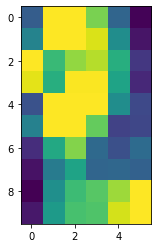

In [49]:
""" Dataloader """
train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
x = next(iter(train_dataloader))
img = x[0].squeeze()
plt.imshow(img)
dataset = CustomDataset(train_dataloader)
#print(dataset.__getitem__(0))
#print(dataset.__getitem__(0)[0].shape)


output_tensor = model(x)
print(output_tensor[0][:10800])

In [50]:
model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


In [51]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [224]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'model.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()

In [52]:
ratio_list = []
self_connections = []
conflicting_connections = []
loss_list = []

In [53]:
# iterate over epochs
#entropy_loss = nn.MSELoss(reduction='none')
entropy_loss = nn.MSELoss(reduction='none')
loss_constant = 1
cstant = 0
stant = 0
vstant = 1e-3
for epoch in range(num_epochs):

    # iterate over training dataset by batch
    for i, s in enumerate(train_dataloader, 0):
        shading_map = s
        shading_map = shading_map.to(device)
        result = model(shading_map)

        average_ratio = 0
        self_c = 0
        conflicting_c = 0

        voltage_list = []
        current_list = []
        power_list = []

        for j in range(0, batch_size):
            embedding = result[j]
            embedding = np.squeeze(embedding.detach())
            embedding, terminal_array = embedding[:10800], embedding[10800:]
            embedding = embedding.reshape(10, 6, 10, 6, 3)
            terminal_array = terminal_array.reshape(10, 6, 2)

            series_connections = torch.count_nonzero(embedding[...,0]) + torch.count_nonzero(embedding[...,1])
            parallel_connections = torch.count_nonzero(embedding[...,2])
            if parallel_connections == 0:
                average_ratio += 0
            elif parallel_connections > 0:
                average_ratio += (series_connections / parallel_connections)

            moduleobj = SolarModule(10, 6)
            moduleobj.embedding = np.array(embedding.numpy(), dtype=bool)
            moduleobj.terminal_array = np.array(terminal_array.numpy(), dtype=bool)

            try:
                moduleobj.make_netlist()
                moduleobj.simulate();
                voltage_list.append(moduleobj.VMP)
                current_list.append(moduleobj.IMP)
                power_list.append(moduleobj.MPP/sum(shading_map.flatten()))
                #print(moduleobj.MPP, moduleobj.VMP, moduleobj.IMP) # normalise power
            except ValueError:
                filtering = moduleobj.filter_embedding()
                self_c += filtering[0]
                conflicting_c += filtering[1]
                #if filtering[0] <= 0 and filtering[1] <= 5:
                try:
                    moduleobj.make_netlist()
                    moduleobj.simulate()
                    voltage_list.append(moduleobj.VMP)
                    current_list.append(moduleobj.IMP)
                    power_list.append(moduleobj.MPP/sum(shading_map.flatten()))
                except:
                    voltage_list.append(0)
                    current_list.append(0)
                    power_list.append(0) 

        average_ratio /= batch_size
        self_c /= batch_size
        conflicting_c /= batch_size
        ratio_list.append(float(average_ratio))
        self_connections.append(self_c)
        conflicting_connections.append(conflicting_c)

        self_c = float(self_c)
        conflicting_c = float(conflicting_c)
        average_ratio = float(average_ratio)

        average_power = float(np.mean(power_list))
        average_voltage = float(np.mean(voltage_list))
        average_current = float(np.mean(current_list))

        loss = torch.tensor(1 - average_power, requires_grad = True)
        loss = loss * loss_constant + (50 - average_voltage) * vstant
        #loss = loss * loss_constant + conflicting_c * cstant + self_c * stant
        
        loss_list.append(float(loss))
        
        """ Possibly have a 'polynomial fit' for the conflicting and self-connection metric. """

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(i, ratio_list[-1], self_connections[-1], conflicting_connections[-1], loss)
        print(average_power, "W", average_voltage, "V", average_current, "A")
    print('Epoch {}: Loss {}'.format(epoch, loss))
    
# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding

0 1.9947006702423096 90.5 1736.0 tensor(0.5185, grad_fn=<AddBackward0>)
0.530817449092865 W 0.6700000000000004 V 581.1604030775416 A
1 2.0022363662719727 88.0 1746.5 tensor(0.4773, grad_fn=<AddBackward0>)
0.5720147490501404 W 0.6700000000000004 V 581.1604030775416 A
2 2.000868082046509 86.5 1737.5 tensor(0.5512, grad_fn=<AddBackward0>)
0.49808746576309204 W 0.6700000000000004 V 581.1604030775416 A
3 2.0089917182922363 92.5 1747.0 tensor(0.4682, grad_fn=<AddBackward0>)
0.5811744928359985 W 0.6700000000000004 V 581.1604030775416 A
4 2.0089430809020996 85.5 1735.0 tensor(0.4038, grad_fn=<AddBackward0>)
0.6455667614936829 W 0.6700000000000004 V 581.1604030775416 A
5 2.0274651050567627 90.0 1732.0 tensor(0.5010, grad_fn=<AddBackward0>)
0.5483537912368774 W 0.6700000000000004 V 581.1604030775416 A
6 2.0039784908294678 86.5 1739.5 tensor(0.5284, grad_fn=<AddBackward0>)
0.5209183692932129 W 0.6700000000000004 V 581.1604030775416 A
7 1.9763274192810059 88.5 1718.5 tensor(0.5226, grad_fn=<AddBac

62 1.9669333696365356 87.0 1734.5 tensor(0.4187, grad_fn=<AddBackward0>)
0.6306127905845642 W 0.6700000000000004 V 581.1604030775416 A
63 1.9939277172088623 85.0 1720.5 tensor(0.3607, grad_fn=<AddBackward0>)
0.6886311173439026 W 0.6700000000000004 V 581.1604030775416 A
64 2.002807378768921 87.0 1720.5 tensor(0.5748, grad_fn=<AddBackward0>)
0.474560409784317 W 0.6700000000000004 V 581.1604030775416 A
65 2.0266709327697754 90.5 1740.5 tensor(0.2909, grad_fn=<AddBackward0>)
0.7584620714187622 W 0.6700000000000004 V 581.1604030775416 A
66 1.9851458072662354 92.0 1736.0 tensor(0.4396, grad_fn=<AddBackward0>)
0.6097492575645447 W 0.6700000000000004 V 581.1604030775416 A
67 2.0090785026550293 88.5 1733.0 tensor(0.4587, grad_fn=<AddBackward0>)
0.5906597971916199 W 0.6700000000000004 V 581.1604030775416 A
68 1.9967643022537231 91.5 1712.5 tensor(0.1154, grad_fn=<AddBackward0>)
0.933978796005249 W 0.6700000000000004 V 581.1604030775416 A
69 2.0321431159973145 90.0 1761.0 tensor(0.3878, grad_fn=<

123 2.0207934379577637 92.0 1744.5 tensor(0.5018, grad_fn=<AddBackward0>)
0.5475592613220215 W 0.6700000000000004 V 581.1604030775416 A
124 2.0073020458221436 94.0 1726.0 tensor(0.5477, grad_fn=<AddBackward0>)
0.5016604661941528 W 0.6700000000000004 V 581.1604030775416 A
125 2.0147411823272705 84.0 1737.0 tensor(0.3952, grad_fn=<AddBackward0>)
0.6541255712509155 W 0.6700000000000004 V 581.1604030775416 A
126 2.023801565170288 87.5 1737.5 tensor(0.4279, grad_fn=<AddBackward0>)
0.6213926672935486 W 0.6700000000000004 V 581.1604030775416 A
127 1.999548316001892 89.5 1724.0 tensor(0.4737, grad_fn=<AddBackward0>)
0.5756177306175232 W 0.6700000000000004 V 581.1604030775416 A
128 2.0094239711761475 89.0 1741.0 tensor(0.4720, grad_fn=<AddBackward0>)
0.577297568321228 W 0.6700000000000004 V 581.1604030775416 A
129 2.0091686248779297 89.5 1720.0 tensor(0.4499, grad_fn=<AddBackward0>)
0.5994681119918823 W 0.6700000000000004 V 581.1604030775416 A
130 1.9841442108154297 91.5 1723.0 tensor(0.3355, g

184 2.0060296058654785 95.5 1726.5 tensor(0.4057, grad_fn=<AddBackward0>)
0.6436693668365479 W 0.6700000000000004 V 581.1604030775416 A
185 2.0131096839904785 90.0 1733.0 tensor(0.4739, grad_fn=<AddBackward0>)
0.5754297375679016 W 0.6700000000000004 V 581.1604030775416 A
186 1.9958584308624268 95.0 1756.0 tensor(0.3069, grad_fn=<AddBackward0>)
0.7424336671829224 W 0.6700000000000004 V 581.1604030775416 A
187 1.9880743026733398 84.5 1717.0 tensor(0.4396, grad_fn=<AddBackward0>)
0.6096851229667664 W 0.6700000000000004 V 581.1604030775416 A
188 2.0209381580352783 91.5 1716.0 tensor(0.2936, grad_fn=<AddBackward0>)
0.7557719945907593 W 0.6700000000000004 V 581.1604030775416 A
189 2.0152227878570557 90.5 1751.5 tensor(0.3815, grad_fn=<AddBackward0>)
0.6678115725517273 W 0.6700000000000004 V 581.1604030775416 A
190 1.9925227165222168 89.5 1729.0 tensor(0.4023, grad_fn=<AddBackward0>)
0.6470304131507874 W 0.6700000000000004 V 581.1604030775416 A
191 2.004119396209717 88.0 1715.0 tensor(0.4071,

245 2.0082902908325195 86.0 1738.0 tensor(0.3762, grad_fn=<AddBackward0>)
0.6731249690055847 W 0.6700000000000004 V 581.1604030775416 A
246 1.98046875 87.5 1747.0 tensor(0.5282, grad_fn=<AddBackward0>)
0.5211277604103088 W 0.6700000000000004 V 581.1604030775416 A
247 2.0214080810546875 88.0 1708.5 tensor(0.4586, grad_fn=<AddBackward0>)
0.5907670855522156 W 0.6700000000000004 V 581.1604030775416 A
248 2.0033273696899414 89.5 1733.5 tensor(0.2419, grad_fn=<AddBackward0>)
0.8074539303779602 W 0.6700000000000004 V 581.1604030775416 A
249 2.0239977836608887 89.0 1727.5 tensor(0.4479, grad_fn=<AddBackward0>)
0.6014500856399536 W 0.6700000000000004 V 581.1604030775416 A
250 2.0141773223876953 90.5 1750.5 tensor(0.7401, grad_fn=<AddBackward0>)
0.309236615896225 W 0.6700000000000004 V 329.32422841061 A
251 1.9721918106079102 89.5 1752.5 tensor(0.5278, grad_fn=<AddBackward0>)
0.5215619206428528 W 0.6700000000000004 V 581.1604030775416 A
252 2.023073673248291 87.5 1725.5 tensor(0.3805, grad_fn=<A

306 2.008557081222534 87.0 1736.5 tensor(0.4985, grad_fn=<AddBackward0>)
0.5508309602737427 W 0.6700000000000004 V 581.1604030775416 A
307 2.0133180618286133 87.0 1731.5 tensor(0.4922, grad_fn=<AddBackward0>)
0.5571054220199585 W 0.6700000000000004 V 581.1604030775416 A
308 1.9760873317718506 80.5 1728.5 tensor(0.2695, grad_fn=<AddBackward0>)
0.7798193097114563 W 0.6700000000000004 V 581.1604030775416 A
309 2.0299291610717773 94.5 1747.0 tensor(0.4937, grad_fn=<AddBackward0>)
0.5556179285049438 W 0.6700000000000004 V 581.1604030775416 A
310 2.008514165878296 83.5 1740.5 tensor(0.4017, grad_fn=<AddBackward0>)
0.6476035714149475 W 0.6700000000000004 V 581.1604030775416 A
311 2.0255308151245117 95.0 1743.0 tensor(0.4505, grad_fn=<AddBackward0>)
0.5988770127296448 W 0.6700000000000004 V 581.1604030775416 A
312 1.9842828512191772 89.5 1722.5 tensor(0.4235, grad_fn=<AddBackward0>)
0.6258025765419006 W 0.6700000000000004 V 581.1604030775416 A
313 2.0304677486419678 90.5 1723.0 tensor(0.5552, 

367 2.0502471923828125 87.0 1717.5 tensor(0.4511, grad_fn=<AddBackward0>)
0.5982576608657837 W 0.6700000000000004 V 581.1604030775416 A
368 2.030005931854248 92.5 1744.5 tensor(0.4053, grad_fn=<AddBackward0>)
0.6440339088439941 W 0.6700000000000004 V 581.1604030775416 A
369 2.0019216537475586 93.5 1741.5 tensor(0.5259, grad_fn=<AddBackward0>)
0.523408055305481 W 0.6700000000000004 V 581.1604030775416 A
370 2.007838726043701 90.5 1744.0 tensor(0.5047, grad_fn=<AddBackward0>)
0.5446414947509766 W 0.6700000000000004 V 581.1604030775416 A
371 2.0277886390686035 85.5 1745.0 tensor(0.5006, grad_fn=<AddBackward0>)
0.548690140247345 W 0.6700000000000004 V 581.1604030775416 A
372 2.0057122707366943 86.0 1744.5 tensor(0.5120, grad_fn=<AddBackward0>)
0.5373618602752686 W 0.6700000000000004 V 581.1604030775416 A
373 1.9759650230407715 89.5 1736.5 tensor(0.3846, grad_fn=<AddBackward0>)
0.6647758483886719 W 0.6700000000000004 V 581.1604030775416 A
374 2.010955333709717 94.0 1724.0 tensor(0.4598, gra

428 1.9978400468826294 87.5 1714.5 tensor(0.5106, grad_fn=<AddBackward0>)
0.5387469530105591 W 0.6700000000000004 V 581.1604030775416 A
429 2.0135645866394043 91.5 1745.0 tensor(0.4132, grad_fn=<AddBackward0>)
0.6361634135246277 W 0.6700000000000004 V 581.1604030775416 A
430 1.9978270530700684 88.5 1741.0 tensor(0.4309, grad_fn=<AddBackward0>)
0.6184336543083191 W 0.6700000000000004 V 581.1604030775416 A
431 2.0133228302001953 91.0 1709.0 tensor(0.4447, grad_fn=<AddBackward0>)
0.6046116948127747 W 0.6700000000000004 V 581.1604030775416 A
432 2.0121588706970215 88.0 1720.5 tensor(0.3318, grad_fn=<AddBackward0>)
0.7175492644309998 W 0.6700000000000004 V 581.1604030775416 A
433 1.9870669841766357 89.0 1722.5 tensor(0.5020, grad_fn=<AddBackward0>)
0.5473024845123291 W 0.6700000000000004 V 581.1604030775416 A
434 1.9955172538757324 92.0 1729.0 tensor(0.2663, grad_fn=<AddBackward0>)
0.7830381393432617 W 0.6700000000000004 V 581.1604030775416 A
435 1.9926598072052002 87.0 1720.0 tensor(0.2767

489 2.0376107692718506 91.5 1722.5 tensor(0.3501, grad_fn=<AddBackward0>)
0.6992032527923584 W 0.6700000000000004 V 581.1604030775416 A
490 2.0127553939819336 89.0 1716.5 tensor(0.5102, grad_fn=<AddBackward0>)
0.5391253232955933 W 0.6700000000000004 V 581.1604030775416 A
491 2.0080904960632324 88.5 1747.0 tensor(0.2965, grad_fn=<AddBackward0>)
0.7528179287910461 W 0.6700000000000004 V 581.1604030775416 A
492 2.035689353942871 91.5 1719.5 tensor(0.4707, grad_fn=<AddBackward0>)
0.5786482691764832 W 0.6700000000000004 V 581.1604030775416 A
493 1.9816689491271973 88.0 1701.5 tensor(0.4281, grad_fn=<AddBackward0>)
0.621269166469574 W 0.6700000000000004 V 581.1604030775416 A
494 1.9765117168426514 82.5 1736.5 tensor(0.4244, grad_fn=<AddBackward0>)
0.6248904466629028 W 0.6700000000000004 V 581.1604030775416 A
495 2.027649402618408 89.0 1720.5 tensor(0.4924, grad_fn=<AddBackward0>)
0.5569043755531311 W 0.6700000000000004 V 581.1604030775416 A
496 1.9922248125076294 89.5 1736.5 tensor(0.4609, g

50 1.9994473457336426 92.0 1731.5 tensor(0.4995, grad_fn=<AddBackward0>)
0.5498622059822083 W 0.6700000000000004 V 581.1604030775416 A
51 1.9910070896148682 86.0 1728.5 tensor(0.3920, grad_fn=<AddBackward0>)
0.6573753356933594 W 0.6700000000000004 V 581.1604030775416 A
52 2.004818916320801 90.0 1734.5 tensor(0.5043, grad_fn=<AddBackward0>)
0.5450009703636169 W 0.6700000000000004 V 581.1604030775416 A
53 2.0201380252838135 95.0 1731.0 tensor(0.2617, grad_fn=<AddBackward0>)
0.787659227848053 W 0.6700000000000004 V 581.1604030775416 A
54 2.0194480419158936 91.0 1761.0 tensor(0.5418, grad_fn=<AddBackward0>)
0.5075252056121826 W 0.6700000000000004 V 581.1604030775416 A
55 2.0091352462768555 90.5 1739.0 tensor(0.4822, grad_fn=<AddBackward0>)
0.5671732425689697 W 0.6700000000000004 V 581.1604030775416 A
56 2.014235019683838 90.0 1726.5 tensor(0.5755, grad_fn=<AddBackward0>)
0.47381868958473206 W 0.6700000000000004 V 581.1604030775416 A
57 1.9847824573516846 91.5 1706.0 tensor(0.4868, grad_fn=

111 2.00465726852417 88.5 1727.5 tensor(0.4806, grad_fn=<AddBackward0>)
0.5686818957328796 W 0.6700000000000004 V 581.1604030775416 A
112 1.9832804203033447 89.5 1721.5 tensor(0.5877, grad_fn=<AddBackward0>)
0.4616228938102722 W 0.6700000000000004 V 581.1604030775416 A
113 2.0042057037353516 92.0 1725.0 tensor(0.4311, grad_fn=<AddBackward0>)
0.6181963682174683 W 0.6700000000000004 V 581.1604030775416 A
114 2.007631540298462 92.0 1727.0 tensor(0.4321, grad_fn=<AddBackward0>)
0.617266833782196 W 0.6700000000000004 V 581.1604030775416 A
115 2.004173755645752 93.5 1755.0 tensor(0.3675, grad_fn=<AddBackward0>)
0.6818634271621704 W 0.6700000000000004 V 581.1604030775416 A
116 2.0249576568603516 88.0 1726.0 tensor(0.4713, grad_fn=<AddBackward0>)
0.5779926776885986 W 0.6700000000000004 V 581.1604030775416 A
117 2.000627040863037 89.0 1698.5 tensor(0.3689, grad_fn=<AddBackward0>)
0.6803997159004211 W 0.6700000000000004 V 581.1604030775416 A
118 2.038625717163086 87.5 1718.5 tensor(0.4016, grad_

172 1.983804702758789 88.0 1746.0 tensor(0.4020, grad_fn=<AddBackward0>)
0.647341787815094 W 0.6700000000000004 V 581.1604030775416 A
173 2.003429412841797 83.5 1733.0 tensor(0.4440, grad_fn=<AddBackward0>)
0.6053729057312012 W 0.6700000000000004 V 581.1604030775416 A
174 2.0353903770446777 92.0 1739.5 tensor(0.5012, grad_fn=<AddBackward0>)
0.5481043457984924 W 0.6700000000000004 V 581.1604030775416 A
175 2.008471727371216 90.5 1707.5 tensor(0.5130, grad_fn=<AddBackward0>)
0.5363421440124512 W 0.6700000000000004 V 581.1604030775416 A
176 2.0185608863830566 88.0 1703.5 tensor(0.4960, grad_fn=<AddBackward0>)
0.5532823204994202 W 0.6700000000000004 V 581.1604030775416 A
177 2.013857364654541 90.5 1730.5 tensor(0.5345, grad_fn=<AddBackward0>)
0.5148217082023621 W 0.6700000000000004 V 581.1604030775416 A
178 1.9723169803619385 85.5 1727.5 tensor(0.4787, grad_fn=<AddBackward0>)
0.5706105828285217 W 0.6700000000000004 V 581.1604030775416 A
179 1.9881646633148193 89.0 1698.5 tensor(0.4402, gra

233 1.989043951034546 83.5 1725.0 tensor(0.4754, grad_fn=<AddBackward0>)
0.5739661455154419 W 0.6700000000000004 V 581.1604030775416 A
234 1.9992949962615967 89.5 1737.5 tensor(0.3090, grad_fn=<AddBackward0>)
0.7402968406677246 W 0.6700000000000004 V 581.1604030775416 A
235 2.019243001937866 91.0 1710.5 tensor(0.4831, grad_fn=<AddBackward0>)
0.5662389397621155 W 0.6700000000000004 V 581.1604030775416 A
236 2.0026369094848633 91.0 1723.0 tensor(0.1433, grad_fn=<AddBackward0>)
0.9059816002845764 W 0.6700000000000004 V 581.1604030775416 A
237 2.0076582431793213 84.5 1749.5 tensor(0.3234, grad_fn=<AddBackward0>)
0.725975751876831 W 0.6700000000000004 V 581.1604030775416 A
238 2.0032074451446533 93.5 1739.5 tensor(0.5043, grad_fn=<AddBackward0>)
0.5450609922409058 W 0.6700000000000004 V 581.1604030775416 A
239 1.9960989952087402 92.5 1726.5 tensor(0.4605, grad_fn=<AddBackward0>)
0.5888150930404663 W 0.6700000000000004 V 581.1604030775416 A
240 1.9865155220031738 92.0 1728.0 tensor(0.3926, g

294 2.0126819610595703 92.0 1738.5 tensor(0.4718, grad_fn=<AddBackward0>)
0.5775766968727112 W 0.6700000000000004 V 581.1604030775416 A
295 2.0224807262420654 86.0 1709.0 tensor(0.4122, grad_fn=<AddBackward0>)
0.6371031999588013 W 0.6700000000000004 V 581.1604030775416 A
296 1.9918479919433594 89.5 1710.0 tensor(0.3922, grad_fn=<AddBackward0>)
0.6570931673049927 W 0.6700000000000004 V 581.1604030775416 A
297 2.012672185897827 88.0 1709.0 tensor(0.4268, grad_fn=<AddBackward0>)
0.6225227117538452 W 0.6700000000000004 V 581.1604030775416 A
298 2.010831594467163 81.5 1712.0 tensor(0.3857, grad_fn=<AddBackward0>)
0.663606584072113 W 0.6700000000000004 V 581.1604030775416 A
299 1.9820358753204346 94.0 1729.0 tensor(0.1398, grad_fn=<AddBackward0>)
0.9095345735549927 W 0.6700000000000004 V 581.1604030775416 A
300 2.0273990631103516 89.5 1720.5 tensor(0.4667, grad_fn=<AddBackward0>)
0.5826306343078613 W 0.6700000000000004 V 581.1604030775416 A
301 1.9944157600402832 83.5 1730.5 tensor(0.5526, g

355 2.0275402069091797 93.0 1743.5 tensor(0.3953, grad_fn=<AddBackward0>)
0.6539947986602783 W 0.6700000000000004 V 581.1604030775416 A
356 2.0022289752960205 90.5 1748.5 tensor(0.4385, grad_fn=<AddBackward0>)
0.6107956171035767 W 0.6700000000000004 V 581.1604030775416 A
357 2.0298876762390137 87.5 1729.5 tensor(0.3604, grad_fn=<AddBackward0>)
0.6889703869819641 W 0.6700000000000004 V 581.1604030775416 A
358 1.9970393180847168 89.5 1732.5 tensor(0.4497, grad_fn=<AddBackward0>)
0.5996579527854919 W 0.6700000000000004 V 581.1604030775416 A
359 1.9908453226089478 91.0 1732.0 tensor(0.4508, grad_fn=<AddBackward0>)
0.5985663533210754 W 0.6700000000000004 V 581.1604030775416 A
360 1.9810312986373901 86.0 1720.5 tensor(0.5090, grad_fn=<AddBackward0>)
0.5403333306312561 W 0.6700000000000004 V 581.1604030775416 A
361 1.9774892330169678 86.5 1748.0 tensor(0.5148, grad_fn=<AddBackward0>)
0.534578800201416 W 0.6700000000000004 V 581.1604030775416 A
362 2.0046098232269287 91.0 1721.5 tensor(0.1995,

416 2.005312204360962 90.0 1726.5 tensor(0.5848, grad_fn=<AddBackward0>)
0.4644802212715149 W 0.6700000000000004 V 581.1604030775416 A
417 1.9750254154205322 85.5 1720.0 tensor(0.3136, grad_fn=<AddBackward0>)
0.7356936931610107 W 0.6700000000000004 V 581.1604030775416 A
418 2.030179023742676 90.5 1738.5 tensor(0.3801, grad_fn=<AddBackward0>)
0.6692073345184326 W 0.6700000000000004 V 581.1604030775416 A
419 2.005321502685547 94.0 1735.0 tensor(0.3849, grad_fn=<AddBackward0>)
0.6644182801246643 W 0.6700000000000004 V 581.1604030775416 A
420 2.0001771450042725 90.0 1734.5 tensor(0.4244, grad_fn=<AddBackward0>)
0.624920666217804 W 0.6700000000000004 V 581.1604030775416 A
421 2.000608205795288 90.5 1740.5 tensor(0.5075, grad_fn=<AddBackward0>)
0.5418378114700317 W 0.6700000000000004 V 581.1604030775416 A
422 2.027625322341919 87.0 1740.5 tensor(0.4366, grad_fn=<AddBackward0>)
0.6126981973648071 W 0.6700000000000004 V 581.1604030775416 A
423 1.994927167892456 91.5 1713.0 tensor(0.2106, grad_

477 2.0015385150909424 86.5 1742.5 tensor(0.5144, grad_fn=<AddBackward0>)
0.53490149974823 W 0.6700000000000004 V 581.1604030775416 A
478 2.0031650066375732 87.5 1721.0 tensor(0.4821, grad_fn=<AddBackward0>)
0.5672245621681213 W 0.6700000000000004 V 581.1604030775416 A
479 2.0014896392822266 91.0 1722.0 tensor(0.4777, grad_fn=<AddBackward0>)
0.5716313123703003 W 0.6700000000000004 V 581.1604030775416 A
480 1.9930591583251953 93.0 1739.0 tensor(0.5560, grad_fn=<AddBackward0>)
0.4933505356311798 W 0.6700000000000004 V 581.1604030775416 A
481 2.0092475414276123 90.5 1727.5 tensor(0.4360, grad_fn=<AddBackward0>)
0.6133262515068054 W 0.6700000000000004 V 581.1604030775416 A
482 2.0063130855560303 91.5 1748.5 tensor(0.5370, grad_fn=<AddBackward0>)
0.5123477578163147 W 0.6700000000000004 V 581.1604030775416 A
483 2.022251605987549 90.5 1720.0 tensor(0.5267, grad_fn=<AddBackward0>)
0.5226585268974304 W 0.6700000000000004 V 581.1604030775416 A
484 2.0101869106292725 89.5 1744.5 tensor(0.5042, g

38 1.9884881973266602 88.0 1726.5 tensor(0.5186, grad_fn=<AddBackward0>)
0.5306889414787292 W 0.6700000000000004 V 581.1604030775416 A
39 1.9815404415130615 95.5 1714.0 tensor(0.3088, grad_fn=<AddBackward0>)
0.7405032515525818 W 0.6700000000000004 V 581.1604030775416 A
40 2.0443124771118164 88.5 1729.5 tensor(0.4310, grad_fn=<AddBackward0>)
0.6183664798736572 W 0.6700000000000004 V 581.1604030775416 A
41 2.011557102203369 89.5 1741.5 tensor(0.2720, grad_fn=<AddBackward0>)
0.7773610353469849 W 0.6700000000000004 V 581.1604030775416 A
42 2.002559185028076 93.5 1731.5 tensor(0.4151, grad_fn=<AddBackward0>)
0.6341868042945862 W 0.6700000000000004 V 581.1604030775416 A
43 2.0039472579956055 91.5 1723.0 tensor(0.5049, grad_fn=<AddBackward0>)
0.5444256067276001 W 0.6700000000000004 V 581.1604030775416 A
44 2.0405006408691406 92.5 1731.5 tensor(0.5523, grad_fn=<AddBackward0>)
0.4970735013484955 W 0.6700000000000004 V 581.1604030775416 A
45 2.017444133758545 93.0 1760.5 tensor(0.5491, grad_fn=<

99 2.013040542602539 86.0 1716.5 tensor(0.3324, grad_fn=<AddBackward0>)
0.7169011235237122 W 0.6700000000000004 V 581.1604030775416 A
100 2.010221481323242 90.0 1722.0 tensor(0.6101, grad_fn=<AddBackward0>)
0.4392208755016327 W 0.6700000000000004 V 348.69624184653003 A
101 1.9971941709518433 90.0 1716.5 tensor(0.4692, grad_fn=<AddBackward0>)
0.5801094174385071 W 0.6700000000000004 V 581.1604030775416 A
102 1.9972007274627686 92.5 1718.5 tensor(0.3603, grad_fn=<AddBackward0>)
0.688999354839325 W 0.6700000000000004 V 581.1604030775416 A
103 1.978992223739624 87.0 1710.0 tensor(0.4159, grad_fn=<AddBackward0>)
0.6334604620933533 W 0.6700000000000004 V 581.1604030775416 A
104 2.002000093460083 88.0 1708.0 tensor(0.4130, grad_fn=<AddBackward0>)
0.6363260746002197 W 0.6700000000000004 V 581.1604030775416 A
105 2.0140771865844727 84.0 1744.0 tensor(0.6206, grad_fn=<AddBackward0>)
0.42877620458602905 W 0.6700000000000004 V 339.01023512857 A
106 2.0008130073547363 90.5 1752.5 tensor(0.5120, grad

160 1.9776456356048584 86.0 1729.5 tensor(0.4589, grad_fn=<AddBackward0>)
0.5904178023338318 W 0.6700000000000004 V 581.1604030775416 A
161 1.997943639755249 97.0 1721.5 tensor(0.1570, grad_fn=<AddBackward0>)
0.8923777341842651 W 0.6700000000000004 V 581.1604030775416 A
162 2.0085506439208984 84.5 1722.0 tensor(0.4188, grad_fn=<AddBackward0>)
0.6305341720581055 W 0.6700000000000004 V 581.1604030775416 A
163 1.9975265264511108 91.0 1729.0 tensor(0.3815, grad_fn=<AddBackward0>)
0.6678110361099243 W 0.6700000000000004 V 581.1604030775416 A
164 1.9891955852508545 87.0 1741.0 tensor(0.4695, grad_fn=<AddBackward0>)
0.579870343208313 W 0.6700000000000004 V 581.1604030775416 A
165 2.039699077606201 91.5 1732.0 tensor(0.2649, grad_fn=<AddBackward0>)
0.7844456434249878 W 0.6700000000000004 V 581.1604030775416 A
166 1.9857233762741089 87.0 1721.5 tensor(0.5316, grad_fn=<AddBackward0>)
0.5177042484283447 W 0.6700000000000004 V 581.1604030775416 A
167 1.9938924312591553 90.5 1747.0 tensor(0.4969, g

221 2.008552074432373 91.0 1740.5 tensor(0.3991, grad_fn=<AddBackward0>)
0.6502555012702942 W 0.6700000000000004 V 581.1604030775416 A
222 2.0181262493133545 92.0 1724.0 tensor(0.5768, grad_fn=<AddBackward0>)
0.4725576341152191 W 0.6700000000000004 V 581.1604030775416 A
223 1.989809274673462 92.5 1714.0 tensor(0.4452, grad_fn=<AddBackward0>)
0.6040869951248169 W 0.6700000000000004 V 581.1604030775416 A
224 2.01301646232605 89.0 1739.5 tensor(0.4783, grad_fn=<AddBackward0>)
0.5710529685020447 W 0.6700000000000004 V 581.1604030775416 A
225 1.9683616161346436 90.0 1723.0 tensor(0.3191, grad_fn=<AddBackward0>)
0.7301851511001587 W 0.6700000000000004 V 581.1604030775416 A
226 2.049717426300049 92.0 1720.0 tensor(0.4022, grad_fn=<AddBackward0>)
0.6471004486083984 W 0.6700000000000004 V 581.1604030775416 A
227 1.9920541048049927 88.5 1731.5 tensor(0.4946, grad_fn=<AddBackward0>)
0.5547485947608948 W 0.6700000000000004 V 581.1604030775416 A
228 2.041011333465576 88.0 1727.5 tensor(0.3728, grad

282 1.9942244291305542 86.0 1725.0 tensor(0.3669, grad_fn=<AddBackward0>)
0.6824675798416138 W 0.6700000000000004 V 581.1604030775416 A
283 1.983708143234253 90.0 1725.0 tensor(0.4690, grad_fn=<AddBackward0>)
0.5803719758987427 W 0.6700000000000004 V 581.1604030775416 A
284 1.9902615547180176 88.0 1738.5 tensor(0.4039, grad_fn=<AddBackward0>)
0.6454339027404785 W 0.6700000000000004 V 581.1604030775416 A
285 2.0221471786499023 88.5 1722.0 tensor(0.3088, grad_fn=<AddBackward0>)
0.7405157685279846 W 0.6700000000000004 V 581.1604030775416 A
286 2.007899522781372 87.0 1728.0 tensor(0.7773, grad_fn=<AddBackward0>)
0.2720511257648468 W 0.6700000000000004 V 314.79521833367016 A
287 2.027647018432617 90.5 1730.5 tensor(0.5054, grad_fn=<AddBackward0>)
0.5439670085906982 W 0.6700000000000004 V 581.1604030775416 A
288 2.003159523010254 86.5 1717.5 tensor(0.4641, grad_fn=<AddBackward0>)
0.5852508544921875 W 0.6700000000000004 V 581.1604030775416 A
289 1.9840292930603027 88.5 1715.5 tensor(0.4999, g

343 2.012356758117676 95.5 1731.0 tensor(0.3909, grad_fn=<AddBackward0>)
0.6584303975105286 W 0.6700000000000004 V 581.1604030775416 A
344 1.977445125579834 88.5 1706.0 tensor(0.3535, grad_fn=<AddBackward0>)
0.695791482925415 W 0.6700000000000004 V 581.1604030775416 A
345 1.9833667278289795 91.5 1727.0 tensor(0.4757, grad_fn=<AddBackward0>)
0.5736204981803894 W 0.6700000000000004 V 581.1604030775416 A
346 1.9956470727920532 89.5 1741.5 tensor(0.2613, grad_fn=<AddBackward0>)
0.7880284190177917 W 0.6700000000000004 V 581.1604030775416 A
347 1.987208366394043 88.5 1713.5 tensor(0.3656, grad_fn=<AddBackward0>)
0.6837593913078308 W 0.6700000000000004 V 581.1604030775416 A
348 2.0281457901000977 89.0 1718.0 tensor(0.5729, grad_fn=<AddBackward0>)
0.47640758752822876 W 0.6700000000000004 V 581.1604030775416 A
349 2.0031073093414307 93.0 1727.0 tensor(0.4582, grad_fn=<AddBackward0>)
0.5910945534706116 W 0.6700000000000004 V 581.1604030775416 A
350 2.0064635276794434 95.0 1726.5 tensor(0.2567, g

404 2.0213637351989746 86.5 1728.5 tensor(0.3071, grad_fn=<AddBackward0>)
0.7422166466712952 W 0.6700000000000004 V 581.1604030775416 A
405 2.007326602935791 92.5 1743.5 tensor(0.4612, grad_fn=<AddBackward0>)
0.5881357192993164 W 0.6700000000000004 V 581.1604030775416 A
406 1.9822431802749634 88.0 1761.5 tensor(0.4840, grad_fn=<AddBackward0>)
0.5653373599052429 W 0.6700000000000004 V 581.1604030775416 A
407 2.005964517593384 89.0 1738.5 tensor(0.2499, grad_fn=<AddBackward0>)
0.7994645833969116 W 0.6700000000000004 V 581.1604030775416 A
408 2.0166397094726562 98.5 1750.5 tensor(0.4426, grad_fn=<AddBackward0>)
0.6067392826080322 W 0.6700000000000004 V 581.1604030775416 A
409 2.0454440116882324 87.0 1734.0 tensor(0.3356, grad_fn=<AddBackward0>)
0.7137048244476318 W 0.6700000000000004 V 581.1604030775416 A
410 1.9915883541107178 81.0 1705.0 tensor(0.1231, grad_fn=<AddBackward0>)
0.9262564778327942 W 0.6700000000000004 V 581.1604030775416 A
411 1.9851338863372803 92.5 1722.5 tensor(0.5453, 

465 2.000830888748169 92.5 1749.5 tensor(0.5018, grad_fn=<AddBackward0>)
0.5475456118583679 W 0.6700000000000004 V 581.1604030775416 A
466 2.007115364074707 86.0 1725.0 tensor(0.1953, grad_fn=<AddBackward0>)
0.854064404964447 W 0.6700000000000004 V 581.1604030775416 A
467 1.9791371822357178 92.0 1740.5 tensor(0.5560, grad_fn=<AddBackward0>)
0.49333399534225464 W 0.6700000000000004 V 581.1604030775416 A
468 2.0269393920898438 87.0 1732.0 tensor(0.4116, grad_fn=<AddBackward0>)
0.637749195098877 W 0.6700000000000004 V 581.1604030775416 A
469 2.010953664779663 90.0 1739.5 tensor(0.4522, grad_fn=<AddBackward0>)
0.597091794013977 W 0.6700000000000004 V 581.1604030775416 A
470 2.023705005645752 89.0 1736.5 tensor(0.3891, grad_fn=<AddBackward0>)
0.6602294445037842 W 0.6700000000000004 V 581.1604030775416 A
471 2.003476619720459 89.5 1721.5 tensor(0.4242, grad_fn=<AddBackward0>)
0.62511146068573 W 0.6700000000000004 V 581.1604030775416 A
472 2.013833522796631 90.0 1732.5 tensor(0.4561, grad_fn=

26 1.9988934993743896 87.5 1735.5 tensor(0.5858, grad_fn=<AddBackward0>)
0.4635632634162903 W 0.6700000000000004 V 581.1604030775416 A
27 2.014146566390991 89.5 1746.0 tensor(0.5798, grad_fn=<AddBackward0>)
0.4695393145084381 W 0.6700000000000004 V 581.1604030775416 A
28 1.970996618270874 88.5 1712.0 tensor(0.5058, grad_fn=<AddBackward0>)
0.5435001254081726 W 0.6700000000000004 V 581.1604030775416 A
29 2.0287222862243652 86.5 1763.0 tensor(0.4845, grad_fn=<AddBackward0>)
0.5648261308670044 W 0.6700000000000004 V 581.1604030775416 A
30 2.0169644355773926 82.5 1732.5 tensor(0.3608, grad_fn=<AddBackward0>)
0.6885159015655518 W 0.6700000000000004 V 581.1604030775416 A
31 1.9890481233596802 90.5 1728.5 tensor(0.1369, grad_fn=<AddBackward0>)
0.9124201536178589 W 0.6700000000000004 V 581.1604030775416 A
32 2.0238423347473145 88.0 1726.0 tensor(0.4802, grad_fn=<AddBackward0>)
0.5691396594047546 W 0.6700000000000004 V 581.1604030775416 A
33 1.9986234903335571 91.5 1710.5 tensor(0.4604, grad_fn=

87 1.9983272552490234 92.5 1729.0 tensor(0.3779, grad_fn=<AddBackward0>)
0.6713868379592896 W 0.6700000000000004 V 581.1604030775416 A
88 1.9969043731689453 88.5 1726.5 tensor(0.4368, grad_fn=<AddBackward0>)
0.6125390529632568 W 0.6700000000000004 V 581.1604030775416 A
89 1.998831868171692 90.0 1719.0 tensor(0.4700, grad_fn=<AddBackward0>)
0.5793342590332031 W 0.6700000000000004 V 581.1604030775416 A
90 1.9944393634796143 91.5 1742.0 tensor(0.3898, grad_fn=<AddBackward0>)
0.6595413088798523 W 0.6700000000000004 V 581.1604030775416 A
91 1.9927515983581543 91.5 1725.0 tensor(0.3571, grad_fn=<AddBackward0>)
0.6922401189804077 W 0.6700000000000004 V 581.1604030775416 A
92 1.9799257516860962 88.0 1715.5 tensor(0.4893, grad_fn=<AddBackward0>)
0.5600231885910034 W 0.6700000000000004 V 581.1604030775416 A
93 2.0093727111816406 90.5 1731.0 tensor(0.5321, grad_fn=<AddBackward0>)
0.5172502994537354 W 0.6700000000000004 V 581.1604030775416 A
94 2.030198812484741 87.0 1741.0 tensor(0.2955, grad_fn=

148 2.018442153930664 96.5 1708.0 tensor(0.5222, grad_fn=<AddBackward0>)
0.5271379351615906 W 0.6700000000000004 V 581.1604030775416 A
149 1.9763214588165283 88.0 1720.5 tensor(0.3754, grad_fn=<AddBackward0>)
0.673952043056488 W 0.6700000000000004 V 581.1604030775416 A
150 1.9908597469329834 94.5 1756.0 tensor(0.4235, grad_fn=<AddBackward0>)
0.625867486000061 W 0.6700000000000004 V 581.1604030775416 A
151 2.0270981788635254 90.5 1725.5 tensor(0.4157, grad_fn=<AddBackward0>)
0.6336100697517395 W 0.6700000000000004 V 581.1604030775416 A
152 2.0192642211914062 90.5 1716.5 tensor(0.4614, grad_fn=<AddBackward0>)
0.5879172682762146 W 0.6700000000000004 V 581.1604030775416 A
153 1.9944490194320679 86.0 1720.5 tensor(0.4687, grad_fn=<AddBackward0>)
0.5806746482849121 W 0.6700000000000004 V 581.1604030775416 A
154 2.008967876434326 90.5 1737.0 tensor(0.4661, grad_fn=<AddBackward0>)
0.5832352042198181 W 0.6700000000000004 V 581.1604030775416 A
155 2.0204997062683105 88.5 1723.5 tensor(0.3036, gr

209 2.0013535022735596 90.0 1731.5 tensor(0.4395, grad_fn=<AddBackward0>)
0.6098043322563171 W 0.6700000000000004 V 581.1604030775416 A
210 1.9981129169464111 87.5 1721.5 tensor(0.3058, grad_fn=<AddBackward0>)
0.7435080409049988 W 0.6700000000000004 V 581.1604030775416 A
211 2.0215296745300293 92.5 1754.5 tensor(0.4792, grad_fn=<AddBackward0>)
0.5701623558998108 W 0.6700000000000004 V 581.1604030775416 A
212 2.038562059402466 93.0 1724.5 tensor(0.3645, grad_fn=<AddBackward0>)
0.6848668456077576 W 0.6700000000000004 V 581.1604030775416 A
213 2.0172715187072754 90.5 1722.0 tensor(0.3731, grad_fn=<AddBackward0>)
0.6762487888336182 W 0.6700000000000004 V 581.1604030775416 A
214 2.01295804977417 88.0 1754.5 tensor(0.4684, grad_fn=<AddBackward0>)
0.5809710025787354 W 0.6700000000000004 V 581.1604030775416 A
215 2.0190682411193848 87.0 1716.5 tensor(0.3579, grad_fn=<AddBackward0>)
0.6913880109786987 W 0.6700000000000004 V 581.1604030775416 A
216 2.013598918914795 90.5 1715.5 tensor(0.4596, gr

270 2.003560781478882 88.5 1737.0 tensor(0.4292, grad_fn=<AddBackward0>)
0.6201030611991882 W 0.6700000000000004 V 581.1604030775416 A
271 2.0537290573120117 90.0 1719.5 tensor(0.2077, grad_fn=<AddBackward0>)
0.8416182994842529 W 0.6700000000000004 V 581.1604030775416 A
272 2.0234265327453613 88.5 1738.0 tensor(0.4823, grad_fn=<AddBackward0>)
0.5670071244239807 W 0.6700000000000004 V 581.1604030775416 A
273 1.9803097248077393 87.5 1730.0 tensor(0.3916, grad_fn=<AddBackward0>)
0.6577027440071106 W 0.6700000000000004 V 581.1604030775416 A
274 2.0054590702056885 82.5 1711.0 tensor(0.4687, grad_fn=<AddBackward0>)
0.5806563496589661 W 0.6700000000000004 V 581.1604030775416 A
275 2.019773006439209 98.0 1738.5 tensor(0.3720, grad_fn=<AddBackward0>)
0.6773130297660828 W 0.6700000000000004 V 581.1604030775416 A
276 1.9878735542297363 87.0 1706.0 tensor(0.4307, grad_fn=<AddBackward0>)
0.6186277866363525 W 0.6700000000000004 V 581.1604030775416 A
277 2.0024209022521973 87.5 1736.0 tensor(0.4127, 

331 2.0324816703796387 93.5 1722.5 tensor(0.6088, grad_fn=<AddBackward0>)
0.44055718183517456 W 0.6700000000000004 V 343.8532384875498 A
332 1.995767593383789 89.0 1736.0 tensor(0.3833, grad_fn=<AddBackward0>)
0.6659874320030212 W 0.6700000000000004 V 581.1604030775416 A
333 2.0155563354492188 88.5 1733.0 tensor(0.3634, grad_fn=<AddBackward0>)
0.6859388947486877 W 0.6700000000000004 V 581.1604030775416 A
334 2.0372912883758545 94.5 1714.0 tensor(0.5087, grad_fn=<AddBackward0>)
0.5405941605567932 W 0.6700000000000004 V 581.1604030775416 A
335 1.9767721891403198 88.5 1727.5 tensor(0.2824, grad_fn=<AddBackward0>)
0.7669230699539185 W 0.6700000000000004 V 581.1604030775416 A
336 2.0000834465026855 91.5 1716.0 tensor(0.4755, grad_fn=<AddBackward0>)
0.573819637298584 W 0.6700000000000004 V 581.1604030775416 A
337 2.0078744888305664 93.5 1752.0 tensor(0.3324, grad_fn=<AddBackward0>)
0.7169650197029114 W 0.6700000000000004 V 581.1604030775416 A
338 2.016119956970215 93.0 1725.0 tensor(0.4232, 

392 1.9989659786224365 85.5 1722.0 tensor(0.5677, grad_fn=<AddBackward0>)
0.48165249824523926 W 0.6700000000000004 V 581.1604030775416 A
393 2.023486852645874 91.0 1731.5 tensor(0.2796, grad_fn=<AddBackward0>)
0.7697675228118896 W 0.6700000000000004 V 581.1604030775416 A
394 1.9597949981689453 86.5 1733.0 tensor(0.4483, grad_fn=<AddBackward0>)
0.6009824872016907 W 0.6700000000000004 V 581.1604030775416 A
395 1.9939515590667725 92.0 1742.0 tensor(0.4960, grad_fn=<AddBackward0>)
0.5533413290977478 W 0.6700000000000004 V 581.1604030775416 A
396 2.0078911781311035 90.0 1727.0 tensor(0.4032, grad_fn=<AddBackward0>)
0.6461008191108704 W 0.6700000000000004 V 581.1604030775416 A
397 1.9964921474456787 87.5 1711.0 tensor(0.4378, grad_fn=<AddBackward0>)
0.611513614654541 W 0.6700000000000004 V 581.1604030775416 A
398 1.999497652053833 90.0 1730.5 tensor(0.4504, grad_fn=<AddBackward0>)
0.5989180207252502 W 0.6700000000000004 V 581.1604030775416 A
399 2.039785623550415 85.5 1729.5 tensor(0.4539, g

453 1.9994776248931885 87.5 1728.0 tensor(0.4005, grad_fn=<AddBackward0>)
0.6488648056983948 W 0.6700000000000004 V 581.1604030775416 A
454 2.020124912261963 92.0 1741.5 tensor(0.5451, grad_fn=<AddBackward0>)
0.5042082667350769 W 0.6700000000000004 V 581.1604030775416 A
455 2.0006465911865234 92.0 1739.0 tensor(0.3308, grad_fn=<AddBackward0>)
0.7185320258140564 W 0.6700000000000004 V 581.1604030775416 A
456 1.9969475269317627 87.5 1741.5 tensor(0.4702, grad_fn=<AddBackward0>)
0.5790949463844299 W 0.6700000000000004 V 581.1604030775416 A
457 2.0270776748657227 92.0 1718.5 tensor(0.4445, grad_fn=<AddBackward0>)
0.6048334240913391 W 0.6700000000000004 V 581.1604030775416 A
458 2.0087881088256836 86.0 1714.0 tensor(0.3254, grad_fn=<AddBackward0>)
0.7239776253700256 W 0.6700000000000004 V 581.1604030775416 A
459 2.014650821685791 90.5 1738.0 tensor(0.4384, grad_fn=<AddBackward0>)
0.6109790205955505 W 0.6700000000000004 V 581.1604030775416 A
460 1.995897889137268 83.0 1734.0 tensor(0.4202, g

14 2.018975019454956 87.5 1738.0 tensor(0.2395, grad_fn=<AddBackward0>)
0.809845507144928 W 0.6700000000000004 V 581.1604030775416 A
15 1.9815335273742676 92.5 1729.0 tensor(0.3920, grad_fn=<AddBackward0>)
0.6573002934455872 W 0.6700000000000004 V 581.1604030775416 A
16 2.0025343894958496 89.5 1729.5 tensor(0.4112, grad_fn=<AddBackward0>)
0.6381224393844604 W 0.6700000000000004 V 581.1604030775416 A
17 1.9902116060256958 86.0 1752.5 tensor(0.2357, grad_fn=<AddBackward0>)
0.8136129975318909 W 0.6700000000000004 V 581.1604030775416 A
18 1.9975383281707764 90.0 1734.0 tensor(0.3509, grad_fn=<AddBackward0>)
0.6984229683876038 W 0.6700000000000004 V 581.1604030775416 A
19 2.029609203338623 93.0 1727.0 tensor(0.4871, grad_fn=<AddBackward0>)
0.5622488260269165 W 0.6700000000000004 V 581.1604030775416 A
20 1.976365089416504 82.0 1719.5 tensor(0.2836, grad_fn=<AddBackward0>)
0.7656881213188171 W 0.6700000000000004 V 581.1604030775416 A
21 1.9720947742462158 91.5 1742.0 tensor(0.4730, grad_fn=<A

75 2.024027109146118 91.5 1760.5 tensor(0.4388, grad_fn=<AddBackward0>)
0.6104864478111267 W 0.6700000000000004 V 581.1604030775416 A
76 2.0223729610443115 83.0 1735.0 tensor(0.4693, grad_fn=<AddBackward0>)
0.5800143480300903 W 0.6700000000000004 V 581.1604030775416 A
77 2.0349178314208984 86.5 1728.5 tensor(0.5239, grad_fn=<AddBackward0>)
0.525417685508728 W 0.6700000000000004 V 581.1604030775416 A
78 2.0041890144348145 89.0 1736.5 tensor(0.5172, grad_fn=<AddBackward0>)
0.5321107506752014 W 0.6700000000000004 V 581.1604030775416 A
79 1.9838619232177734 89.0 1717.0 tensor(0.3647, grad_fn=<AddBackward0>)
0.6845862865447998 W 0.6700000000000004 V 581.1604030775416 A
80 1.9998626708984375 95.0 1724.5 tensor(0.4389, grad_fn=<AddBackward0>)
0.6104307770729065 W 0.6700000000000004 V 581.1604030775416 A
81 1.9807138442993164 89.5 1732.0 tensor(0.4415, grad_fn=<AddBackward0>)
0.6077867746353149 W 0.6700000000000004 V 581.1604030775416 A
82 2.002720594406128 90.5 1740.5 tensor(0.4487, grad_fn=<

136 2.0017426013946533 93.5 1739.5 tensor(0.2359, grad_fn=<AddBackward0>)
0.8133808374404907 W 0.6700000000000004 V 581.1604030775416 A
137 2.0263659954071045 93.0 1752.0 tensor(0.4562, grad_fn=<AddBackward0>)
0.5931742191314697 W 0.6700000000000004 V 581.1604030775416 A
138 2.044778347015381 91.5 1734.0 tensor(0.4591, grad_fn=<AddBackward0>)
0.5902295112609863 W 0.6700000000000004 V 581.1604030775416 A
139 2.014524459838867 85.5 1723.0 tensor(0.4512, grad_fn=<AddBackward0>)
0.5980974435806274 W 0.6700000000000004 V 581.1604030775416 A
140 1.9752469062805176 90.0 1723.0 tensor(0.5275, grad_fn=<AddBackward0>)
0.5218496918678284 W 0.6700000000000004 V 581.1604030775416 A
141 1.988509178161621 87.0 1719.5 tensor(0.5278, grad_fn=<AddBackward0>)
0.5215262770652771 W 0.6700000000000004 V 581.1604030775416 A
142 1.9777147769927979 83.0 1737.0 tensor(0.3232, grad_fn=<AddBackward0>)
0.7261709570884705 W 0.6700000000000004 V 581.1604030775416 A
143 2.020392894744873 87.0 1723.5 tensor(0.3742, gr

197 1.9961302280426025 91.0 1722.5 tensor(0.4454, grad_fn=<AddBackward0>)
0.603954017162323 W 0.6700000000000004 V 581.1604030775416 A
198 2.0072383880615234 93.0 1753.0 tensor(0.4701, grad_fn=<AddBackward0>)
0.5792498588562012 W 0.6700000000000004 V 581.1604030775416 A
199 1.9956612586975098 91.5 1729.0 tensor(0.4059, grad_fn=<AddBackward0>)
0.6434611082077026 W 0.6700000000000004 V 581.1604030775416 A
200 1.991640329360962 82.0 1712.5 tensor(0.3633, grad_fn=<AddBackward0>)
0.6860694885253906 W 0.6700000000000004 V 581.1604030775416 A
201 2.0308454036712646 86.5 1706.0 tensor(0.4904, grad_fn=<AddBackward0>)
0.5588826537132263 W 0.6700000000000004 V 581.1604030775416 A
202 1.9943615198135376 85.5 1721.5 tensor(0.4728, grad_fn=<AddBackward0>)
0.5765180587768555 W 0.6700000000000004 V 581.1604030775416 A
203 2.0075550079345703 88.5 1741.0 tensor(0.3832, grad_fn=<AddBackward0>)
0.6661070585250854 W 0.6700000000000004 V 581.1604030775416 A
204 2.0248594284057617 91.0 1752.0 tensor(0.4309, 

258 1.9753618240356445 92.0 1730.0 tensor(0.2782, grad_fn=<AddBackward0>)
0.7711389660835266 W 0.6700000000000004 V 581.1604030775416 A
259 2.00620698928833 86.0 1743.0 tensor(0.5819, grad_fn=<AddBackward0>)
0.4674236476421356 W 0.6700000000000004 V 581.1604030775416 A
260 1.9866228103637695 90.5 1747.0 tensor(0.4997, grad_fn=<AddBackward0>)
0.5496198534965515 W 0.6700000000000004 V 581.1604030775416 A
261 1.9994513988494873 90.5 1733.5 tensor(0.3875, grad_fn=<AddBackward0>)
0.6618175506591797 W 0.6700000000000004 V 581.1604030775416 A
262 1.998314619064331 89.0 1729.5 tensor(0.4811, grad_fn=<AddBackward0>)
0.568236231803894 W 0.6700000000000004 V 581.1604030775416 A
263 2.0087976455688477 91.0 1728.5 tensor(0.4869, grad_fn=<AddBackward0>)
0.5623920559883118 W 0.6700000000000004 V 581.1604030775416 A
264 1.9934982061386108 86.5 1707.0 tensor(0.5429, grad_fn=<AddBackward0>)
0.506436288356781 W 0.6700000000000004 V 581.1604030775416 A
265 1.9458122253417969 87.0 1728.5 tensor(0.5071, gra

319 2.0147509574890137 86.5 1719.5 tensor(0.5495, grad_fn=<AddBackward0>)
0.49985361099243164 W 0.6700000000000004 V 581.1604030775416 A
320 2.0275425910949707 91.5 1713.0 tensor(0.4557, grad_fn=<AddBackward0>)
0.593657910823822 W 0.6700000000000004 V 581.1604030775416 A
321 2.036191463470459 90.5 1737.0 tensor(0.4127, grad_fn=<AddBackward0>)
0.6366757750511169 W 0.6700000000000004 V 581.1604030775416 A
322 2.016162872314453 86.5 1710.5 tensor(0.4697, grad_fn=<AddBackward0>)
0.5796142220497131 W 0.6700000000000004 V 581.1604030775416 A
323 1.9983007907867432 86.5 1709.0 tensor(0.4795, grad_fn=<AddBackward0>)
0.569835901260376 W 0.6700000000000004 V 581.1604030775416 A
324 2.0187318325042725 86.5 1714.5 tensor(0.2639, grad_fn=<AddBackward0>)
0.7854130864143372 W 0.6700000000000004 V 581.1604030775416 A
325 1.9585460424423218 86.0 1704.5 tensor(0.4174, grad_fn=<AddBackward0>)
0.6319005489349365 W 0.6700000000000004 V 581.1604030775416 A
326 2.012166976928711 84.5 1729.5 tensor(0.4151, gr

380 1.9809918403625488 90.0 1721.0 tensor(0.6934, grad_fn=<AddBackward0>)
0.35594356060028076 W 0.6700000000000004 V 343.8532384875498 A
381 2.00262188911438 88.0 1724.0 tensor(0.2694, grad_fn=<AddBackward0>)
0.7799786329269409 W 0.6700000000000004 V 581.1604030775416 A
382 1.9974372386932373 91.5 1730.5 tensor(0.4160, grad_fn=<AddBackward0>)
0.6333614587783813 W 0.6700000000000004 V 581.1604030775416 A
383 2.020702838897705 85.5 1747.0 tensor(0.3045, grad_fn=<AddBackward0>)
0.744830310344696 W 0.6700000000000004 V 581.1604030775416 A
384 2.0143206119537354 88.0 1741.0 tensor(0.3294, grad_fn=<AddBackward0>)
0.7199319005012512 W 0.6700000000000004 V 581.1604030775416 A
385 2.029719114303589 93.5 1718.5 tensor(0.4059, grad_fn=<AddBackward0>)
0.6434365510940552 W 0.6700000000000004 V 581.1604030775416 A
386 2.017279624938965 86.5 1728.5 tensor(0.6954, grad_fn=<AddBackward0>)
0.35390982031822205 W 0.6700000000000004 V 295.4232048977507 A
387 1.9924644231796265 86.5 1730.0 tensor(0.3731, gr

441 2.0163111686706543 93.0 1735.0 tensor(0.4390, grad_fn=<AddBackward0>)
0.6103769540786743 W 0.6700000000000004 V 581.1604030775416 A
442 2.0170822143554688 87.0 1693.5 tensor(0.3309, grad_fn=<AddBackward0>)
0.7184395790100098 W 0.6700000000000004 V 581.1604030775416 A
443 1.9795966148376465 86.5 1726.0 tensor(0.2916, grad_fn=<AddBackward0>)
0.757713258266449 W 0.6700000000000004 V 581.1604030775416 A
444 1.9915260076522827 90.5 1717.0 tensor(0.2989, grad_fn=<AddBackward0>)
0.7504574656486511 W 0.6700000000000004 V 581.1604030775416 A
445 2.0275611877441406 90.0 1734.0 tensor(0.4499, grad_fn=<AddBackward0>)
0.5994706749916077 W 0.6700000000000004 V 581.1604030775416 A
446 1.9972267150878906 89.5 1738.0 tensor(0.3288, grad_fn=<AddBackward0>)
0.7205341458320618 W 0.6700000000000004 V 581.1604030775416 A
447 2.0262444019317627 89.0 1728.0 tensor(0.2318, grad_fn=<AddBackward0>)
0.8174833059310913 W 0.6700000000000004 V 581.1604030775416 A
448 1.9617818593978882 90.0 1731.0 tensor(0.5844,

2 1.9829797744750977 91.0 1715.5 tensor(0.4169, grad_fn=<AddBackward0>)
0.6324310898780823 W 0.6700000000000004 V 581.1604030775416 A
3 2.003328323364258 90.5 1734.5 tensor(0.4822, grad_fn=<AddBackward0>)
0.5671676397323608 W 0.6700000000000004 V 581.1604030775416 A
4 1.9972858428955078 89.0 1722.5 tensor(0.4010, grad_fn=<AddBackward0>)
0.6483380794525146 W 0.6700000000000004 V 581.1604030775416 A
5 2.0038504600524902 90.0 1737.5 tensor(0.3812, grad_fn=<AddBackward0>)
0.668146014213562 W 0.6700000000000004 V 581.1604030775416 A
6 1.999176263809204 90.5 1742.0 tensor(0.4794, grad_fn=<AddBackward0>)
0.5699617862701416 W 0.6700000000000004 V 581.1604030775416 A
7 1.9884319305419922 89.0 1724.0 tensor(0.4577, grad_fn=<AddBackward0>)
0.5915977954864502 W 0.6700000000000004 V 581.1604030775416 A
8 1.9905898571014404 90.5 1736.5 tensor(0.4778, grad_fn=<AddBackward0>)
0.5715502500534058 W 0.6700000000000004 V 581.1604030775416 A
9 2.0318827629089355 87.0 1749.0 tensor(0.4690, grad_fn=<AddBackw

63 2.017385959625244 91.0 1725.5 tensor(0.2626, grad_fn=<AddBackward0>)
0.7867417931556702 W 0.6700000000000004 V 581.1604030775416 A
64 2.0055959224700928 88.5 1735.0 tensor(0.3821, grad_fn=<AddBackward0>)
0.667273998260498 W 0.6700000000000004 V 581.1604030775416 A
65 2.0150299072265625 94.5 1732.0 tensor(0.4654, grad_fn=<AddBackward0>)
0.5839381814002991 W 0.6700000000000004 V 581.1604030775416 A
66 2.0011210441589355 91.5 1724.5 tensor(0.5121, grad_fn=<AddBackward0>)
0.5372737050056458 W 0.6700000000000004 V 581.1604030775416 A
67 2.0068020820617676 88.5 1750.5 tensor(0.4619, grad_fn=<AddBackward0>)
0.5874399542808533 W 0.6700000000000004 V 581.1604030775416 A
68 2.0130228996276855 90.0 1714.5 tensor(0.4629, grad_fn=<AddBackward0>)
0.5864334106445312 W 0.6700000000000004 V 581.1604030775416 A
69 1.9751187562942505 90.5 1729.5 tensor(0.3663, grad_fn=<AddBackward0>)
0.6830224394798279 W 0.6700000000000004 V 581.1604030775416 A
70 2.0235519409179688 87.5 1731.0 tensor(0.4436, grad_fn=

124 1.999777913093567 88.5 1715.0 tensor(0.5008, grad_fn=<AddBackward0>)
0.5485056042671204 W 0.6700000000000004 V 581.1604030775416 A
125 2.0109915733337402 87.0 1731.0 tensor(0.3741, grad_fn=<AddBackward0>)
0.6751819252967834 W 0.6700000000000004 V 581.1604030775416 A
126 2.013045310974121 90.5 1705.0 tensor(0.4209, grad_fn=<AddBackward0>)
0.6284719109535217 W 0.6700000000000004 V 581.1604030775416 A
127 2.0213022232055664 86.0 1731.0 tensor(0.4862, grad_fn=<AddBackward0>)
0.5631179809570312 W 0.6700000000000004 V 581.1604030775416 A
128 1.9952614307403564 92.5 1741.5 tensor(0.4744, grad_fn=<AddBackward0>)
0.5749483108520508 W 0.6700000000000004 V 581.1604030775416 A
129 1.9981145858764648 88.0 1736.0 tensor(0.5937, grad_fn=<AddBackward0>)
0.45563697814941406 W 0.6700000000000004 V 581.1604030775416 A
130 2.0070667266845703 90.0 1727.5 tensor(0.4505, grad_fn=<AddBackward0>)
0.598838210105896 W 0.6700000000000004 V 581.1604030775416 A
131 2.036694049835205 89.0 1722.5 tensor(0.3661, g

185 1.9966564178466797 89.5 1727.0 tensor(0.5228, grad_fn=<AddBackward0>)
0.5265474319458008 W 0.6700000000000004 V 581.1604030775416 A
186 2.011378765106201 89.0 1718.0 tensor(0.4288, grad_fn=<AddBackward0>)
0.6205565333366394 W 0.6700000000000004 V 581.1604030775416 A
187 2.010768413543701 86.0 1732.5 tensor(0.3226, grad_fn=<AddBackward0>)
0.7266892194747925 W 0.6700000000000004 V 581.1604030775416 A
188 2.003369092941284 89.0 1730.0 tensor(0.4385, grad_fn=<AddBackward0>)
0.6108512878417969 W 0.6700000000000004 V 581.1604030775416 A
189 2.0043704509735107 86.5 1743.0 tensor(0.5911, grad_fn=<AddBackward0>)
0.45821020007133484 W 0.6700000000000004 V 581.1604030775416 A
190 1.995530128479004 81.5 1739.0 tensor(0.4502, grad_fn=<AddBackward0>)
0.5991371870040894 W 0.6700000000000004 V 581.1604030775416 A
191 1.9982426166534424 92.5 1730.5 tensor(0.4054, grad_fn=<AddBackward0>)
0.6439225673675537 W 0.6700000000000004 V 581.1604030775416 A
192 2.00761079788208 90.0 1730.5 tensor(0.4911, gra

246 2.0066680908203125 88.0 1709.5 tensor(0.4479, grad_fn=<AddBackward0>)
0.6013998985290527 W 0.6700000000000004 V 581.1604030775416 A
247 2.018721103668213 88.5 1701.0 tensor(0.3198, grad_fn=<AddBackward0>)
0.7295258045196533 W 0.6700000000000004 V 581.1604030775416 A
248 1.9675357341766357 86.5 1723.0 tensor(0.5067, grad_fn=<AddBackward0>)
0.5426282286643982 W 0.6700000000000004 V 581.1604030775416 A
249 2.007681131362915 90.5 1713.5 tensor(0.4555, grad_fn=<AddBackward0>)
0.5938481092453003 W 0.6700000000000004 V 581.1604030775416 A
250 1.9855270385742188 88.5 1739.0 tensor(0.5777, grad_fn=<AddBackward0>)
0.4716331362724304 W 0.6700000000000004 V 581.1604030775416 A
251 2.0221099853515625 85.0 1738.5 tensor(0.3854, grad_fn=<AddBackward0>)
0.6639653444290161 W 0.6700000000000004 V 581.1604030775416 A
252 1.9713482856750488 88.0 1716.0 tensor(0.5143, grad_fn=<AddBackward0>)
0.5350538492202759 W 0.6700000000000004 V 581.1604030775416 A
253 1.9941351413726807 92.0 1729.0 tensor(0.4199, 

307 1.9905476570129395 89.5 1749.0 tensor(0.5063, grad_fn=<AddBackward0>)
0.5430577397346497 W 0.6700000000000004 V 581.1604030775416 A
308 1.9885170459747314 93.0 1710.0 tensor(0.5231, grad_fn=<AddBackward0>)
0.5262677073478699 W 0.6700000000000004 V 581.1604030775416 A
309 2.02016282081604 91.5 1725.5 tensor(0.4112, grad_fn=<AddBackward0>)
0.6380845904350281 W 0.6700000000000004 V 581.1604030775416 A
310 2.022840976715088 92.0 1745.5 tensor(0.5030, grad_fn=<AddBackward0>)
0.5463506579399109 W 0.6700000000000004 V 581.1604030775416 A
311 2.0144262313842773 94.0 1730.0 tensor(0.2793, grad_fn=<AddBackward0>)
0.7700773477554321 W 0.6700000000000004 V 581.1604030775416 A
312 2.001128673553467 91.5 1757.5 tensor(0.4821, grad_fn=<AddBackward0>)
0.5672725439071655 W 0.6700000000000004 V 581.1604030775416 A
313 2.0143942832946777 89.0 1722.5 tensor(0.5152, grad_fn=<AddBackward0>)
0.5340853333473206 W 0.6700000000000004 V 581.1604030775416 A
314 2.015791177749634 93.5 1725.5 tensor(0.4454, gra

368 2.0225400924682617 89.5 1743.5 tensor(0.5041, grad_fn=<AddBackward0>)
0.5452755689620972 W 0.6700000000000004 V 581.1604030775416 A
369 2.015497922897339 88.5 1734.0 tensor(0.2851, grad_fn=<AddBackward0>)
0.7642018795013428 W 0.6700000000000004 V 581.1604030775416 A
370 2.0005550384521484 87.0 1716.0 tensor(0.5019, grad_fn=<AddBackward0>)
0.5474492907524109 W 0.6700000000000004 V 581.1604030775416 A
371 2.000588893890381 90.5 1725.5 tensor(0.5398, grad_fn=<AddBackward0>)
0.5095455050468445 W 0.6700000000000004 V 581.1604030775416 A
372 2.009800434112549 86.0 1722.5 tensor(0.4925, grad_fn=<AddBackward0>)
0.5568224787712097 W 0.6700000000000004 V 581.1604030775416 A
373 1.975167989730835 89.0 1713.5 tensor(0.4993, grad_fn=<AddBackward0>)
0.5499963164329529 W 0.6700000000000004 V 581.1604030775416 A
374 2.030153274536133 86.0 1723.5 tensor(0.5149, grad_fn=<AddBackward0>)
0.5344074964523315 W 0.6700000000000004 V 581.1604030775416 A
375 2.0200929641723633 91.0 1735.5 tensor(0.3443, gra

429 2.0209569931030273 90.5 1744.5 tensor(0.5527, grad_fn=<AddBackward0>)
0.49661970138549805 W 0.6700000000000004 V 581.1604030775416 A
430 1.9650392532348633 87.0 1710.5 tensor(0.4368, grad_fn=<AddBackward0>)
0.6125074625015259 W 0.6700000000000004 V 581.1604030775416 A
431 2.0147125720977783 93.0 1725.5 tensor(0.3977, grad_fn=<AddBackward0>)
0.6516323089599609 W 0.6700000000000004 V 581.1604030775416 A
432 2.0053887367248535 89.0 1741.0 tensor(0.3517, grad_fn=<AddBackward0>)
0.6975981593132019 W 0.6700000000000004 V 581.1604030775416 A
433 2.0491929054260254 91.0 1740.5 tensor(0.4404, grad_fn=<AddBackward0>)
0.6089341044425964 W 0.6700000000000004 V 581.1604030775416 A
434 1.9968786239624023 87.0 1747.0 tensor(0.4344, grad_fn=<AddBackward0>)
0.6149758696556091 W 0.6700000000000004 V 581.1604030775416 A
435 2.0073819160461426 90.0 1724.0 tensor(0.4640, grad_fn=<AddBackward0>)
0.5852989554405212 W 0.6700000000000004 V 581.1604030775416 A
436 1.9966380596160889 92.0 1733.5 tensor(0.527

490 2.007911443710327 87.5 1717.5 tensor(0.4194, grad_fn=<AddBackward0>)
0.6299796104431152 W 0.6700000000000004 V 581.1604030775416 A
491 2.004197120666504 89.0 1747.5 tensor(0.5276, grad_fn=<AddBackward0>)
0.5216972827911377 W 0.6700000000000004 V 581.1604030775416 A
492 2.01678204536438 84.5 1714.0 tensor(0.3565, grad_fn=<AddBackward0>)
0.6928397417068481 W 0.6700000000000004 V 581.1604030775416 A
493 1.9742999076843262 82.5 1719.5 tensor(0.5237, grad_fn=<AddBackward0>)
0.5256466865539551 W 0.6700000000000004 V 581.1604030775416 A
494 2.0127992630004883 89.5 1733.5 tensor(0.4306, grad_fn=<AddBackward0>)
0.6187310814857483 W 0.6700000000000004 V 581.1604030775416 A
495 2.014087200164795 96.0 1733.0 tensor(0.5424, grad_fn=<AddBackward0>)
0.5069422125816345 W 0.6700000000000004 V 581.1604030775416 A
496 1.9935752153396606 91.5 1708.5 tensor(0.2885, grad_fn=<AddBackward0>)
0.7608286738395691 W 0.6700000000000004 V 581.1604030775416 A
497 2.0132761001586914 90.0 1721.5 tensor(0.4071, gra

51 1.9694045782089233 86.0 1732.5 tensor(0.3679, grad_fn=<AddBackward0>)
0.6814610362052917 W 0.6700000000000004 V 581.1604030775416 A
52 2.0054054260253906 89.0 1732.0 tensor(0.4420, grad_fn=<AddBackward0>)
0.6073731184005737 W 0.6700000000000004 V 581.1604030775416 A
53 2.00457763671875 87.5 1736.0 tensor(0.4361, grad_fn=<AddBackward0>)
0.6132380366325378 W 0.6700000000000004 V 581.1604030775416 A
54 1.9872711896896362 84.5 1692.5 tensor(0.4734, grad_fn=<AddBackward0>)
0.5759052634239197 W 0.6700000000000004 V 581.1604030775416 A
55 2.0112557411193848 91.0 1742.0 tensor(0.2477, grad_fn=<AddBackward0>)
0.8016406893730164 W 0.6700000000000004 V 581.1604030775416 A
56 2.004059314727783 90.5 1713.0 tensor(0.4112, grad_fn=<AddBackward0>)
0.6381399035453796 W 0.6700000000000004 V 581.1604030775416 A
57 2.0162599086761475 94.0 1756.5 tensor(0.5320, grad_fn=<AddBackward0>)
0.5173648595809937 W 0.6700000000000004 V 581.1604030775416 A
58 2.0099663734436035 89.0 1729.5 tensor(0.4131, grad_fn=<

112 2.0012590885162354 93.5 1733.5 tensor(0.4645, grad_fn=<AddBackward0>)
0.5848516225814819 W 0.6700000000000004 V 581.1604030775416 A
113 1.9847657680511475 96.5 1742.5 tensor(0.4561, grad_fn=<AddBackward0>)
0.5932192206382751 W 0.6700000000000004 V 581.1604030775416 A
114 2.0440475940704346 89.0 1740.0 tensor(0.4740, grad_fn=<AddBackward0>)
0.5752854347229004 W 0.6700000000000004 V 581.1604030775416 A
115 2.028238534927368 96.0 1746.0 tensor(0.4634, grad_fn=<AddBackward0>)
0.5859140753746033 W 0.6700000000000004 V 581.1604030775416 A
116 2.018594264984131 90.0 1731.5 tensor(0.5472, grad_fn=<AddBackward0>)
0.502155601978302 W 0.6700000000000004 V 581.1604030775416 A
117 1.9828650951385498 90.5 1705.5 tensor(0.5156, grad_fn=<AddBackward0>)
0.5337583422660828 W 0.6700000000000004 V 581.1604030775416 A
118 2.007863759994507 87.5 1719.0 tensor(0.3706, grad_fn=<AddBackward0>)
0.6787605285644531 W 0.6700000000000004 V 581.1604030775416 A
119 2.0286316871643066 93.0 1716.5 tensor(0.3272, gr

KeyboardInterrupt: 

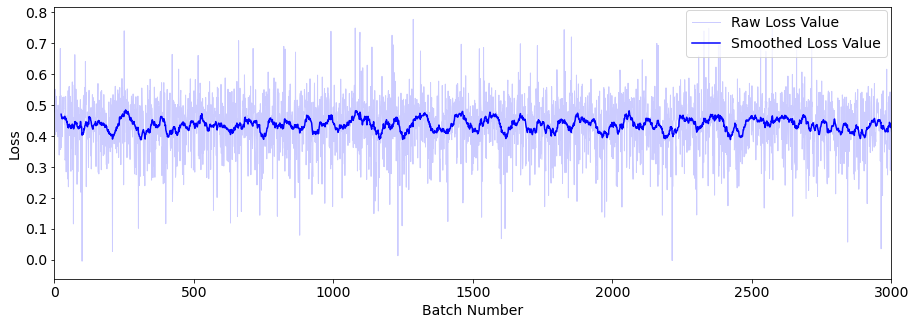

In [60]:
fig, ax1 = plt.subplots(figsize=(15,5))

window_size = 25
smoothed = pd.Series(loss_list).rolling(window_size).mean().tolist()

ax1.tick_params(axis='both', labelsize=14)

ax1.plot(loss_list,linewidth=1,alpha=0.2,color='blue',label='Raw Loss Value')
ax1.plot(smoothed, linewidth=1.5,alpha=1,color='blue',label='Smoothed Loss Value')
ax1.set_xlabel('Batch Number',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
#ax1.set_ylabel('SP Ratio')
ax1.set_xlim(0, 3000)
#ax1.set_ylim(0.01,1)
#ax1.set_yscale('log')
#ax2 = ax1.twinx()
#ax2.set_yscale('log')
#ax2.set_ylim(1,10000)
#ax2.set_ylabel('Number of conflicting connections',fontsize=14)
#ax2.plot(conflicting_connections,linewidth=1.2,color='red',label='Number of Conflicting Connections')
fig.legend(loc='upper right', bbox_to_anchor=(0.902,0.89),fontsize=14)
plt.savefig('training_graph.png',dpi=300,bbox_inches="tight")

In [ ]:
""" Load in evaluation series"""
read_in = pd.read_csv("evaluation_series.csv", header=0, names=['Shading Maps'], usecols=[1])
eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [ ]:
class EvalDataset(Dataset):
    def __init__(self, series):
        self.series = series
    def __getitem__(self, index):
        shading_map = self.series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        return shading_map
    def __len__(self):
        return len(self.series)
evaldataset = EvalDataset(eval_series)
test_loader = torch.utils.data.DataLoader(evaldataset, batch_size=1)

In [ ]:
embedding_list = []
terminal_list = []
power_list = []

In [ ]:
''' evaluate model & visualise outputs'''
model.eval()
with torch.no_grad():
    # get single random image batch from test dataset
    for s in random.sample(list(test_loader), 100):
        
        # push images to gpu
        shading_map = s.to(device)
        # plot input image
        #plt.imshow(np.squeeze(shading_map))
        #plt.figure()
        # compute output image
        result = model(shading_map)
        #print(result)
        # get output image from gpu, reshape
        
        result = np.squeeze(result).cpu().numpy()
        embedding, terminal_array = result[:10800], result[10800:]        
        #print(embedding.shape)
        #print(terminal_array.shape)
        embedding = embedding.reshape(10, 6, 10, 6, 3)
        embedding = np.array(embedding, dtype=bool)
        
        embedding_list.append(np.copy(embedding)) # copy is required as filter_embedding() modifies both the embedding
                                                  # and the terminal array
        
        terminal_array = terminal_array.reshape(10, 6, 2)
        terminal_array = np.array(terminal_array, dtype=bool)
        
        terminal_list.append(np.copy(terminal_array))
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = embedding
        moduleobj.terminal_array = terminal_array
        moduleobj.shading_map = np.squeeze(shading_map).cpu().numpy()*10
        
        try:
            moduleobj.make_netlist()
        except ValueError:
            print(moduleobj.filter_embedding())
            moduleobj.make_netlist()
        
        try:
            moduleobj.simulate()
            power_list.append(round(moduleobj.MPP, 2))
            print("{} W, {} V, {} A".format(round(moduleobj.MPP, 2), round(moduleobj.VMP, 2), round(moduleobj.IMP, 2)))
        #moduleobj.plot_netlist(ymax=300)
        #moduleobj.imshow(3, 3)
        except:
            power_list.append(0)
            print("Simulation failed") 
        break

In [ ]:
embedding_list[0] == embedding_list[2]

In [ ]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'Checkpoints/unsupervised-epochs1batchsize32.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [ ]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'Checkpoints/Batch42FromInit.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()